In [ ]:
import os
import re
from pathlib import Path

import numpy as np
import scipy as sp
import scipy.spatial

from matplotlib import pyplot as plt
from sklearn.manifold import MDS
from sklearn import manifold
from sklearn.decomposition import PCA

import ot
import shutil
from tqdm import tqdm

import ipynbname
import torch
from torch.autograd.functional import jacobian

import multiprocessing as mp

## IMPORT USER DEFINED LIBRARIES ##################################################################
import utils


/home/pzr7pr/Desktop/GW_BCM/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Exploration to determine differences between Frobenius and GW costs

# Utils

In [ ]:
import secrets

def simplex_grid(N=20):
    """Generate points on a 2D simplex grid (triangle) with N divisions per edge."""    
    N = N
    pts = []
    for l in range(N + 1):
        for j in range(N + 1 - l):
            k = N - l - j
            pts.append((l / N, j / N, k / N))
    pts=np.array(pts)
    return pts

def random_rbf_deformation(pts,
                           num_ctrl=20,
                           sigma=0.3,
                           max_disp=0.3,
                           seed=None):
    """
    pts: (N, 2) array in some domain, e.g. [0,1]^2
    num_ctrl: number of random control points
    sigma: RBF width (in units of the domain)
    max_disp: max magnitude of control displacements (same units as coords)
    """
    if seed is None:
        seed = secrets.randbits(256)
    rng = np.random.default_rng(seed)

    # 1) Random control points within bounding box of pts
    mins = pts.min(axis=0)
    maxs = pts.max(axis=0)
    ctrl_pts = rng.uniform(mins, maxs, size=(num_ctrl, 2))

    # 2) Random displacements assigned to control points
    ctrl_disp = rng.uniform(-max_disp, max_disp, size=(num_ctrl, 2))

    # 3) Compute RBF weights for each data point
    #    shape: (N, num_ctrl)
    diff = pts[:, None, :] - ctrl_pts[None, :, :]      # (N, K, 2)
    sqdist = np.sum(diff**2, axis=-1)                  # (N, K)
    weights = np.exp(-sqdist / (2.0 * sigma**2))       # (N, K)

    # Normalize weights so they don't blow up
    weights_sum = np.sum(weights, axis=1, keepdims=True) + 1e-12
    weights = weights / weights_sum

    # 4) Interpolated displacement field at pts
    disp = weights @ ctrl_disp                          # (N, 2)

    # 5) Deformed points
    pts_deformed = pts + disp
    return pts_deformed, disp, ctrl_pts, ctrl_disp, seed


def plot_point_cloud(pts, title='Point Cloud'):
    """Plot 2D point cloud. pts is (N, 2) array."""
    plt.figure(figsize=(4,4))
    plt.scatter(pts[:,0], pts[:,1], s=10, c='k')
    plt.xlim(-0.1,1.1)
    plt.ylim(-0.1,1.1)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(title)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid()
    plt.show() 

def compute_distance_matrix(pts):
    """Compute pairwise Euclidean distance matrix for pts."""
    diff = pts[:, None, :] - pts[None, :, :]  # (N, N, 2)
    dist_matrix = np.sqrt(np.sum(diff**2, axis=-1))  # (N, N)
    return dist_matrix  

def find_last_run_folder(base_dir, prefix="run_"):
    """
    Finds the last run folder (e.g., run_01, run_02, ...) inside base_dir.
    Returns the full path of the last folder.
    """
    pattern = re.compile(rf"{prefix}(\d+)$")
    max_n = -1
    last_folder = None

    for name in os.listdir(base_dir):
        match = pattern.match(name)
        if match:
            n = int(match.group(1))
            if n > max_n:
                max_n = n
                last_folder = os.path.join(base_dir, name)

    return last_folder

def get_Fs(matrix_temp_list, measure_temp_list, matrix_input, measure_input):
    '''
    Computes the auxiliary matrices F_s for the Gromov-Wasserstein barycenter problem.

    Input:
      matrix_temp_list: List of S template matrices (Ns x Ns) representing different dissimilarity matrices.
      measure_temp_list: List of S probability vectors (length Ns), representing probability measures of the S templates.
      matrix_input: (M x M) matrix representing the dissimilarity matrix to analyze (array).
      measure_input: Probability vector of length M (array)

    Output:
      F_list: List of auxiliary matrices F_s for the Gromov-Wasserstein barycenter problem. (list of arrays)
    '''

    S = len(matrix_temp_list)  # Number of template matrices

    pi_list = []  # List to store Gromov-Wasserstein transport plans
    F_list = []  # List to store transformed matrices

    # Compute Q matrix (inverse of the outer product of measure_input)
    Q = (measure_input.reshape(-1, 1) @ measure_input.reshape(1, -1))
    Q = 1. / Q  # Element-wise inverse

    # Compute Gromov-Wasserstein transport maps and one iteration of the forward GW-barycenter problem
    for s in range(S):
        # Compute optimal transport plan (pi_s) using Gromov-Wasserstein transport
        pi_s = ot.gromov.gromov_wasserstein(matrix_temp_list[s], matrix_input,
                                            measure_temp_list[s], measure_input)
        pi_list.append(pi_s)

        # Compute F_s transformation using Q and pi_s
        F_s = Q * (pi_s.T @ matrix_temp_list[s] @ pi_s)  # Element-wise multiplication
        F_list.append(F_s)
    
    return F_list

def get_norm_F(lambdas, matrix_temp_list, measure_temp_list, matrix_input, measure_input):
    '''
    Computes the F norm of the difference between the weighted sum of auxiliary matrices F_s and the input.

    Input:
        lambdas: Weights for each template matrix (array of length S).
        matrix_temp_list: List of S template matrices (Ns x Ns) representing different dissimilarity matrices.
        measure_temp_list: List of S probability vectors (length Ns), representing probability measures of the S templates.
        matrix_input: (M x M) matrix representing the dissimilarity matrix to analyze (array).
        measure_input: Probability vector of length M (array)
    Output:
        norm_F: Frobenius norm of the difference between matrix_input and the weighted sum of F_s matrices. (float)
    '''

    F_list = get_Fs(matrix_temp_list, measure_temp_list, matrix_input, measure_input)
    F_weighted_sum = sum(lambdas[s] * F_list[s] for s in range(len(F_list)))
    norm_F = np.linalg.norm(matrix_input - F_weighted_sum, 'fro')
    return norm_F

def improved_synth(weights, matrix_temp_list, measure_temp_list):
    ot_bary = ot.gromov.gromov_barycenters(
        matrix_temp_list[0].shape[0], 
        Cs = matrix_temp_list, 
        lambdas=weights, 
        loss_fun='square_loss'
        )
    F_list = get_Fs(matrix_temp_list, measure_temp_list, ot_bary, ot.unif(ot_bary.shape[0]))
    improved_bary = sum(weights[s] * F_list[s] for s in range(len(F_list)))
    print(np.linalg.norm(ot_bary-improved_bary,'fro'))
    return improved_bary


# Load

In [ ]:
# ----------------------------------------------
# Load (target)template and the first three deformed point clouds 
# ----------------------------------------------
base_dir = Path('./20-Exp-generated_data')
output_dir = Path(find_last_run_folder(base_dir, prefix="run_"))

# Load template distance matrix to use as target
template_data = np.load(output_dir / 'template_point_cloud.npz')     
template_dist_matrix = template_data['distance_matrix']
target_dist_matrix = template_dist_matrix
target_measure = ot.unif(template_dist_matrix.shape[0])

# Load first three deformed point clouds   
assert len(os.listdir(output_dir)) >= 4, "Need at least 3 deformed point clouds saved."     
deformed_dist_matrices = []
deformed_measures = []
for idx in range(1, 4):
    deformed_data = np.load(output_dir / f'deformed_point_cloud_{idx}.npz')
    deformed_pts = deformed_data['points']
    deformed_dist_matrix = deformed_data['distance_matrix']
    deformed_dist_matrices.append(deformed_dist_matrix)
    deformed_measures.append(ot.unif(deformed_dist_matrix.shape[0]))

# ----------------------------------------------
# Load distance between barycenters and target data
# ----------------------------------------------
bary_dist_data = np.load(output_dir / 'Bary_distances_to_target.npz')
simplex_grid_points = bary_dist_data['simplex_grid_points']
simplex_gromov_wasserstein_distances_to_target = bary_dist_data['simplex_gromov_wasserstein_distances_to_target']



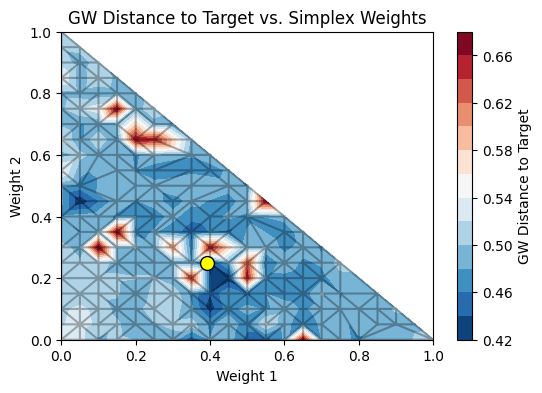

In [ ]:
import matplotlib.tri as tri

# Compute analysis of target 
_, lambdas = utils.get_lambdas_constraints(deformed_dist_matrices,deformed_measures,target_dist_matrix, target_measure)

# Clean up NaN values for plotting
z = simplex_gromov_wasserstein_distances_to_target
mask = np.isnan(z)
z_masked = z[~mask]
x_grid_points = simplex_grid_points[~mask,0]
y_grid_points = simplex_grid_points[~mask,1]

# Plot GW distances to target vs. simplex weights
plt.figure(figsize=(6,4))
plt.tricontourf(x_grid_points, y_grid_points, z_masked, levels=14, cmap="RdBu_r")
plt.colorbar(label='GW Distance to Target')
plt.xlabel('Weight 1')
plt.ylabel('Weight 2')
plt.title('GW Distance to Target vs. Simplex Weights')
# Add triangulation grid
triang = tri.Triangulation(x_grid_points, y_grid_points)
plt.triplot(triang, color='k', alpha=0.3)
plt.scatter(lambdas[0], lambdas[1], color='yellow', s=100, edgecolor='k', label='Computed Weights')
plt.show()

100%|██████████| 21/21 [00:00<00:00, 151.35it/s]


<Figure size 600x400 with 0 Axes>

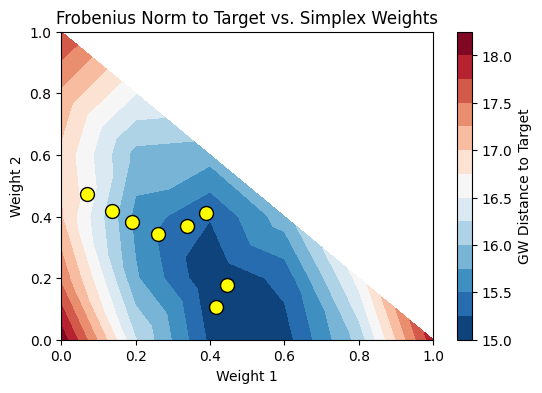

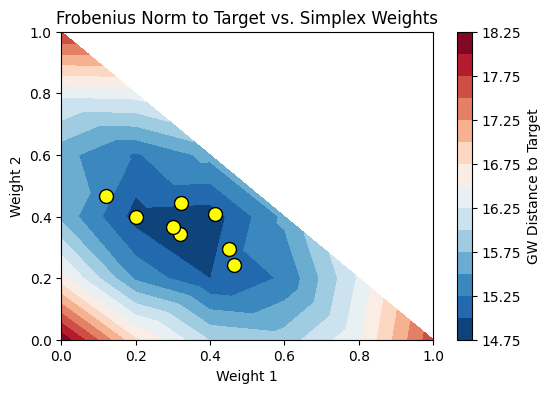

In [ ]:
# Iterate over weights in the simplex and compute GW barycenters and their GW distances to the target
target_dist_matrix_permuted = template_dist_matrix.copy()
simplex_grid_points = simplex_grid(N=5)

plt.figure(figsize=(6,4))
for _ in range(2):
    simplex_frobenius_distances_to_permuted_target = []
    for weight_idx, weight in enumerate(tqdm(simplex_grid_points)):
        weights = weight / np.sum(weight)  # Normalize to sum to 1
        norm_F = get_norm_F(weights, deformed_dist_matrices, deformed_measures, target_dist_matrix_permuted, ot.unif(target_dist_matrix_permuted.shape[0]))
        simplex_frobenius_distances_to_permuted_target.append(norm_F)
    
    # Clean up NaN values for plotting
    z = np.array(simplex_frobenius_distances_to_permuted_target)
    mask = np.isnan(z)
    z_masked = z[~mask]
    x_grid_points = simplex_grid_points[~mask,0]
    y_grid_points = simplex_grid_points[~mask,1]

    # Plot GW distances to target vs. simplex weights
    plt.figure(figsize=(6,4))
    plt.tricontourf(x_grid_points, y_grid_points, z_masked, levels=14, cmap="RdBu_r")
    plt.colorbar(label='GW Distance to Target')
    plt.xlabel('Weight 1')
    plt.ylabel('Weight 2')
    plt.title('Frobenius Norm to Target vs. Simplex Weights')
    # Add triangulation grid
    #triang = tri.Triangulation(x_grid_points, y_grid_points)
    #plt.triplot(triang, color='k', alpha=0.3)

    perm = np.random.permutation(target_dist_matrix_permuted.shape[0])
    target_dist_matrix_permuted = target_dist_matrix_permuted[perm][:, perm]

    recovered_lambdas = []
    for _ in range(8):
        _, lambdas = utils.get_lambdas_constraints(deformed_dist_matrices,deformed_measures,target_dist_matrix_permuted, ot.unif(target_dist_matrix_permuted.shape[0]))
        plt.scatter(lambdas[0], lambdas[1], color='yellow', s=100, edgecolor='k', label='Computed Weights')
        recovered_lambdas.append(lambdas)
        #plt.show()

        perm = np.random.permutation(target_dist_matrix_permuted.shape[0])
        target_dist_matrix_permuted = target_dist_matrix_permuted[perm][:, perm]

plt.show()

# True barycenter and permutations heat map 

Analysis method for true barycenters is independent of matrix permutations. 


In [ ]:
import signal 

# ----------------------------------------------
# Set up signal handler for timeout with custom exception
# ----------------------------------------------

# Creates a custom exception to be raised by the handler and test in except blocks
class TimeoutException(Exception): 
    pass
# Custom signal handler that is called when the signal is received
def timeout_handler(signum, frame): 
    raise TimeoutException

# Set the signal handler for SIGALRM to our custom handler
signal.signal(signal.SIGALRM, timeout_handler) 

<Handlers.SIG_DFL: 0>

In [ ]:
# ----------------------------------------------
# Show that two synthetized barycenters with same weights can be at non-zero GW distance
# ---------------------------------------------- 
lambda_test  = np.array([0.2, 0.3, 0.5])
np.random.seed(42)
target_dist_matrix_permuted = ot.gromov.gromov_barycenters(
    template_dist_matrix.shape[0], 
    Cs = deformed_dist_matrices, 
    lambdas=lambda_test, 
    loss_fun='square_loss'
)
np.random.seed(42)
recomputed_target_dist_matrix_permuted = ot.gromov.gromov_barycenters(
    template_dist_matrix.shape[0], 
    Cs = deformed_dist_matrices, 
    lambdas=lambda_test, 
    loss_fun='square_loss'
)
dist = ot.gromov.gromov_wasserstein2(
    target_dist_matrix_permuted, 
    recomputed_target_dist_matrix_permuted, 
    ot.unif(target_dist_matrix_permuted.shape[0]), 
    ot.unif(recomputed_target_dist_matrix_permuted.shape[0]), 
    'square_loss'
    )
print(f"GW distance between two barycenters with same weights: {dist}")

# ----------------------------------------------
# Test if two improved synthetized barycenters with same weights can be at non-zero GW distance
# ---------------------------------------------- 
lambda_test  = np.array([0.2, 0.3, 0.5])
target_dist_matrix_permuted = improved_synth(lambda_test,deformed_dist_matrices,deformed_measures)
recomputed_target_dist_matrix_permuted = improved_synth(lambda_test,deformed_dist_matrices,deformed_measures)
dist = np.linalg.norm(target_dist_matrix_permuted-recomputed_target_dist_matrix_permuted,'fro')
# dist = ot.gromov.gromov_wasserstein2(
#     target_dist_matrix_permuted, 
#     recomputed_target_dist_matrix_permuted, 
#     ot.unif(target_dist_matrix_permuted.shape[0]), 
#     ot.unif(recomputed_target_dist_matrix_permuted.shape[0]), 
#     'square_loss'
#     )
print(f"GW distance between two barycenters with same weights: {dist}")


GW distance between two barycenters with same weights: -3.608224830031759e-16
3.6685689923153964e-15
3.383676747769095e-15
GW distance between two barycenters with same weights: 21.1478910697253


100%|██████████| 66/66 [00:24<00:00,  2.69it/s]


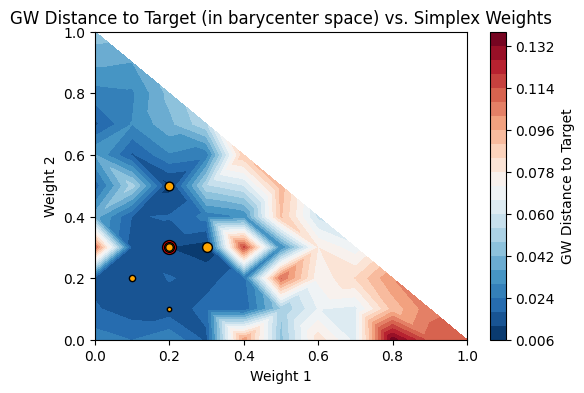

In [ ]:
#------------------------------------------------------------
# Plot distances to targets in Frobernius and GW cases when targets are permuted matrices of a real GW barycenter
#------------------------------------------------------------

lambda_test  = np.array([0.2, 0.3, 0.5])
target_dist_matrix_permuted = ot.gromov.gromov_barycenters(
    template_dist_matrix.shape[0], 
    Cs = deformed_dist_matrices, 
    lambdas=lambda_test, 
    loss_fun='square_loss'
)
simplex_grid_points = simplex_grid(N=10)

# ------------------------------------------------------------
# Computre GW distances to original target and plot results
# ------------------------------------------------------------
if True: # Disable this block to replot once GW distances are computed
    simplex_GW_distances_to_target = []
    for weight_idx, weight in enumerate(tqdm(simplex_grid_points)):
        weights = weight / np.sum(weight)  # Normalize to sum to 1
        try:
            signal.alarm(3)
            barycenter_dist_matrix = ot.gromov.gromov_barycenters(
                template_dist_matrix.shape[0], 
                Cs = deformed_dist_matrices, 
                lambdas=weights, 
                loss_fun='square_loss'
            )
            gw_dist_to_target = ot.gromov.gromov_wasserstein2(
                barycenter_dist_matrix,
                target_dist_matrix_permuted,
                ot.unif(barycenter_dist_matrix.shape[0]),
                ot.unif(target_dist_matrix.shape[0]),
                'square_loss'
                )
            signal.alarm(0)  # Disable the alarm
            simplex_GW_distances_to_target.append(gw_dist_to_target)
        except TimeoutException:
            simplex_GW_distances_to_target.append(np.nan)


# Clean up NaN values for plotting
z = np.array(simplex_GW_distances_to_target)
mask = np.isnan(z)
z_masked = z[~mask]
x_grid_points = simplex_grid_points[~mask,0]
y_grid_points = simplex_grid_points[~mask,1]
min_simplex_grid_points = simplex_grid_points[z.argsort()[:5]]

# Plot GW distances to target vs. simplex weights
plt.figure(figsize=(6,4))
plt.tricontourf(x_grid_points, y_grid_points, z_masked, levels=24, cmap="RdBu_r")
plt.colorbar(label='GW Distance to Target')
plt.xlabel('Weight 1')
plt.ylabel('Weight 2')
plt.title('GW Distance to Target (in barycenter space) vs. Simplex Weights')
# # Plot triangulation grid
# triang = tri.Triangulation(x_grid_points, y_grid_points)
# plt.triplot(triang, color='k', alpha=0.3)
# Plot true and recovered weights
plt.scatter(lambda_test[0], lambda_test[1], color='red', s=100, edgecolor='k', label='Target')
_, lambdas = utils.get_lambdas_constraints(deformed_dist_matrices,deformed_measures,target_dist_matrix_permuted, ot.unif(target_dist_matrix_permuted.shape[0]))
plt.scatter(lambdas[0], lambdas[1], color='yellow', s=50, edgecolor='k', label='Computed Weights our algorithm')
for index, min_point in enumerate(min_simplex_grid_points):
    plt.scatter(min_point[0], min_point[1], color='orange', s=50-10*index, edgecolor='k', label=f'GW Min Weights N {index+1}')
#plt.legend()
plt.show()


100%|██████████| 66/66 [00:00<00:00, 133.59it/s]


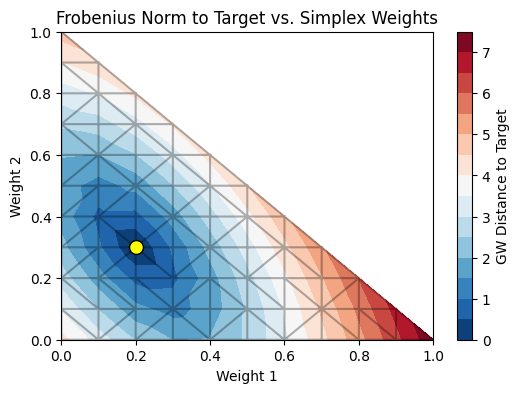

100%|██████████| 66/66 [00:00<00:00, 144.68it/s]


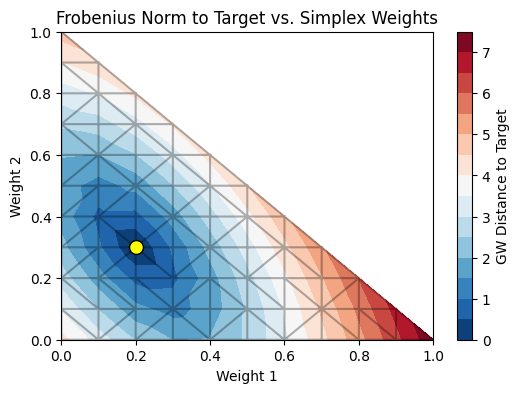

100%|██████████| 66/66 [00:00<00:00, 135.12it/s]


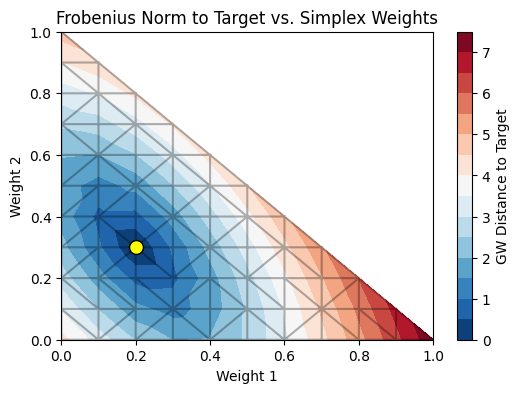

100%|██████████| 66/66 [00:00<00:00, 132.09it/s]


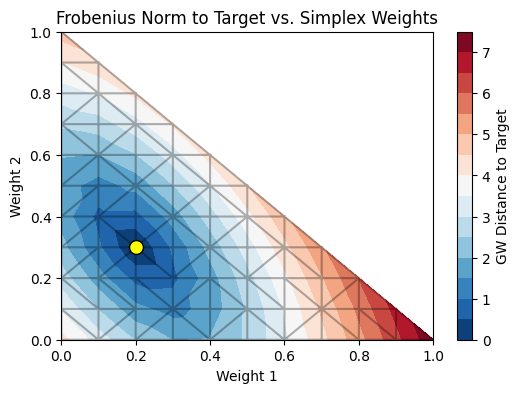

100%|██████████| 66/66 [00:00<00:00, 128.37it/s]


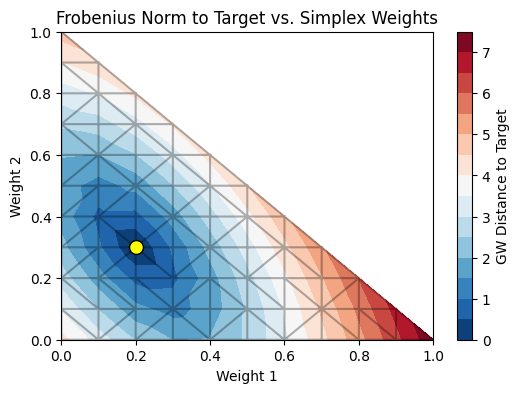

In [ ]:
# ------------------------------------------------------------
# Compute Frobenius distances to original and permuted targets and plot results
# ------------------------------------------------------------

# Generate a barycenter to use as target
lambda_test  = np.array([0.2, 0.3, 0.5])
target_dist_matrix_permuted = ot.gromov.gromov_barycenters(
    template_dist_matrix.shape[0], 
    Cs = deformed_dist_matrices, 
    lambdas=lambda_test, 
    loss_fun='square_loss'
)
simplex_grid_points = simplex_grid(N=10)


# Compute analysis of target and permuted versions of the target
for _ in range(5):
    simplex_frobenius_distances_to_permuted_target = []
    for weight_idx, weight in enumerate(tqdm(simplex_grid_points)):
        weights = weight / np.sum(weight)  # Normalize to sum to 1
        norm_F = get_norm_F(weights, deformed_dist_matrices, deformed_measures, target_dist_matrix_permuted, ot.unif(target_dist_matrix_permuted.shape[0]))
        simplex_frobenius_distances_to_permuted_target.append(norm_F)
    
    # Clean up NaN values for plotting
    z = np.array(simplex_frobenius_distances_to_permuted_target)
    mask = np.isnan(z)
    z_masked = z[~mask]
    x_grid_points = simplex_grid_points[~mask,0]
    y_grid_points = simplex_grid_points[~mask,1]

    # Plot GW distances to target vs. simplex weights
    plt.figure(figsize=(6,4))
    plt.tricontourf(x_grid_points, y_grid_points, z_masked, levels=14, cmap="RdBu_r")
    plt.colorbar(label='GW Distance to Target')
    plt.xlabel('Weight 1')
    plt.ylabel('Weight 2')
    plt.title('Frobenius Norm to Target vs. Simplex Weights')
    # Add triangulation grid
    triang = tri.Triangulation(x_grid_points, y_grid_points)
    plt.triplot(triang, color='k', alpha=0.3)
    _, lambdas = utils.get_lambdas_constraints(deformed_dist_matrices,deformed_measures,target_dist_matrix_permuted, ot.unif(target_dist_matrix_permuted.shape[0]))
    plt.scatter(lambdas[0], lambdas[1], color='yellow', s=100, edgecolor='k', label='Computed Weights')
    plt.show()

    perm = np.random.permutation(target_dist_matrix_permuted.shape[0])
    target_dist_matrix_permuted = target_dist_matrix_permuted[perm][:, perm]

100%|██████████| 66/66 [00:00<00:00, 169.87it/s]


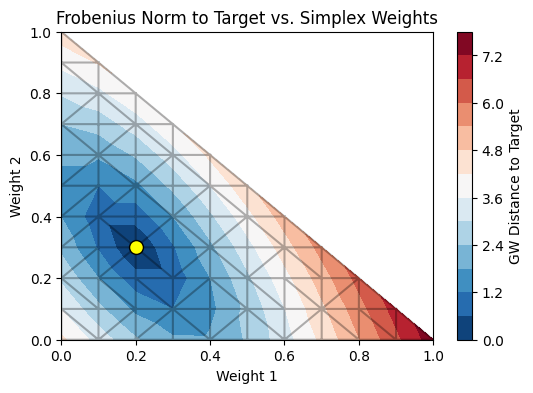

100%|██████████| 66/66 [00:00<00:00, 180.39it/s]


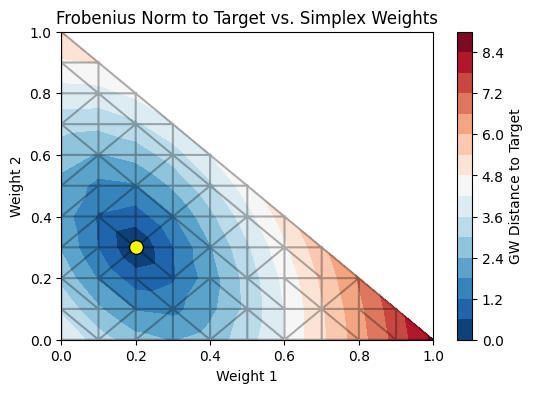

100%|██████████| 66/66 [00:00<00:00, 141.19it/s]


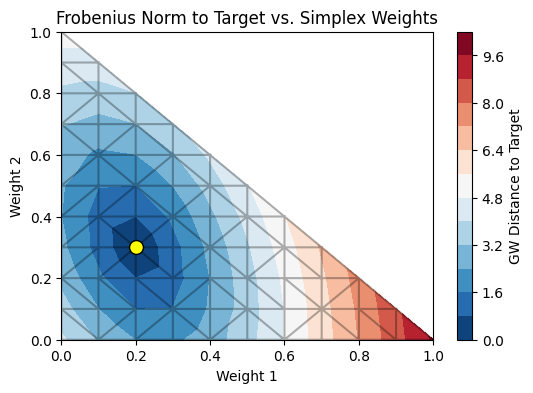

100%|██████████| 66/66 [00:00<00:00, 153.27it/s]


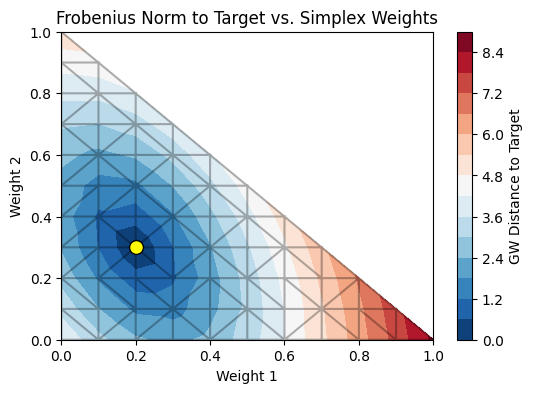

100%|██████████| 66/66 [00:00<00:00, 132.32it/s]


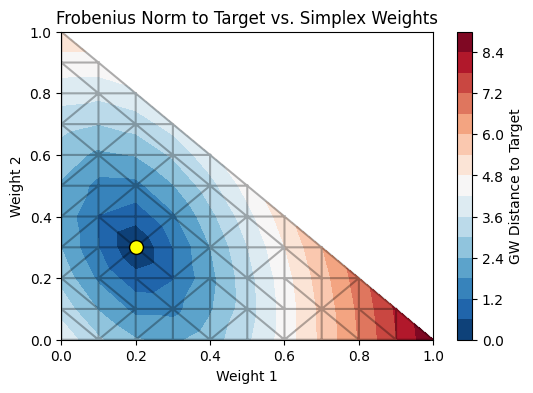

In [ ]:
# ------------------------------------------------------------
# Compute Frobenius distances to different sinthetized targets with same weights
# ------------------------------------------------------------

# Generate a barycenter to use as target
lambda_test  = np.array([0.2, 0.3, 0.5])

# Compute analysis of target and permuted versions of the target
for _ in range(5):
    target_dist_synth_matrix = ot.gromov.gromov_barycenters(
        template_dist_matrix.shape[0], 
        Cs = deformed_dist_matrices, 
        lambdas=lambda_test, 
        loss_fun='square_loss'
        )   
    
    simplex_grid_points = simplex_grid(N=10)
    simplex_frobenius_distances_to_synth_target = []
    for weight_idx, weight in enumerate(tqdm(simplex_grid_points)):
        weights = weight / np.sum(weight)  # Normalize to sum to 1
        norm_F = get_norm_F(weights, deformed_dist_matrices, deformed_measures, target_dist_synth_matrix, ot.unif(target_dist_synth_matrix.shape[0]))
        simplex_frobenius_distances_to_synth_target.append(norm_F)
    
    # Clean up NaN values for plotting
    z = np.array(simplex_frobenius_distances_to_synth_target)
    mask = np.isnan(z)
    z_masked = z[~mask]
    x_grid_points = simplex_grid_points[~mask,0]
    y_grid_points = simplex_grid_points[~mask,1]

    # Plot GW distances to target vs. simplex weights
    plt.figure(figsize=(6,4))
    plt.tricontourf(x_grid_points, y_grid_points, z_masked, levels=14, cmap="RdBu_r")
    plt.colorbar(label='GW Distance to Target')
    plt.xlabel('Weight 1')
    plt.ylabel('Weight 2')
    plt.title('Frobenius Norm to Target vs. Simplex Weights')
    # Add triangulation grid
    triang = tri.Triangulation(x_grid_points, y_grid_points)
    plt.triplot(triang, color='k', alpha=0.3)
    _, lambdas = utils.get_lambdas_constraints(deformed_dist_matrices,deformed_measures,target_dist_synth_matrix, ot.unif(target_dist_synth_matrix.shape[0]))
    plt.scatter(lambdas[0], lambdas[1], color='yellow', s=100, edgecolor='k', label='Computed Weights')
    plt.show()


Real Barycentric Target found


  8%|▊         | 5/66 [00:00<00:01, 41.74it/s]

[np.float64(28.719499377482006), np.float64(0.0)]
[np.float64(27.343346003861576), np.float64(1.402453642182049), np.float64(0.6180180101125192), np.float64(0.6098692004550104), np.float64(0.5869737005103665), np.float64(0.0)]
[np.float64(26.924813085469477), np.float64(2.063272203591922), np.float64(0.03251848860988711), np.float64(0.0)]
[np.float64(26.407055312017285), np.float64(5.197638438944061), np.float64(4.457733547238073), np.float64(2.1213892045962193), np.float64(0.0)]
[np.float64(26.936584993157155), np.float64(1.8873729708636515), np.float64(3.3406965999138447), np.float64(4.0884063321381845), np.float64(1.6623313538185085), np.float64(1.0249938620257772), np.float64(0.3103517957511108), np.float64(0.38380101900483565), np.float64(0.0)]
[np.float64(26.230716587018414), np.float64(3.2914211596763887), np.float64(3.898249706657991), np.float64(1.1994936298524739), np.float64(0.4011491620384582), np.float64(0.0)]
[np.float64(27.915317367285752), np.float64(4.689036808550724),

 15%|█▌        | 10/66 [00:00<00:01, 41.97it/s]

[np.float64(27.701810076529828), np.float64(2.2793226401478544), np.float64(0.13524021302339698), np.float64(0.0)]
[np.float64(27.982939112994217), np.float64(0.0)]


 23%|██▎       | 15/66 [00:03<00:13,  3.75it/s]

[np.float64(28.118628969213034), np.float64(1.030366642318953), np.float64(1.3359933344500996), np.float64(1.3027364213577686), np.float64(5.66070580963221), np.float64(0.8821987822318917), np.float64(1.4922679274548565), np.float64(1.225082936720435), np.float64(6.127976117207089), np.float64(1.2387242147975388), np.float64(1.225082936720435), np.float64(6.12797611720709), np.float64(1.2387242147975388), np.float64(1.225082936720435), np.float64(6.127976117207089), np.float64(1.2387242147975388), np.float64(1.225082936720435), np.float64(6.127976117207089), np.float64(1.2387242147975388), np.float64(1.225082936720435), np.float64(6.127976117207089), np.float64(1.2387242147975388), np.float64(1.225082936720435), np.float64(6.127976117207089), np.float64(1.2387242147975388), np.float64(1.225082936720435), np.float64(6.127976117207089), np.float64(1.2387242147975388), np.float64(1.225082936720435), np.float64(6.127976117207089), np.float64(1.2387242147975388), np.float64(1.22508293672043

 27%|██▋       | 18/66 [00:16<01:08,  1.44s/it]

[np.float64(25.928231994819352), np.float64(7.434323220370965), np.float64(7.664057787545647), np.float64(1.3788811658346276), np.float64(3.6815029958743177), np.float64(1.7132044573090666), np.float64(3.0264818103191313), np.float64(1.285270144204063), np.float64(1.1620584081270342), np.float64(1.1600456409857802), np.float64(1.1600456409857802), np.float64(1.1600456409857802), np.float64(1.1600456409857802), np.float64(1.1600456409857802), np.float64(1.1600456409857802), np.float64(1.1600456409857802), np.float64(1.1600456409857802), np.float64(1.1600456409857802), np.float64(1.1600456409857802), np.float64(1.1600456409857802), np.float64(1.1600456409857802), np.float64(1.1600456409857802), np.float64(1.1600456409857802), np.float64(1.1600456409857802), np.float64(1.1600456409857802), np.float64(1.1600456409857802), np.float64(1.1600456409857802), np.float64(1.1600456409857802), np.float64(1.1600456409857802), np.float64(1.1600456409857802), np.float64(1.1600456409857802), np.float64

 36%|███▋      | 24/66 [00:16<00:31,  1.34it/s]

[np.float64(26.23259186555162), np.float64(2.5418498570516435), np.float64(0.692226251249562), np.float64(1.0756016138958533), np.float64(1.0371463256977587), np.float64(1.3083852269070766), np.float64(0.26678562350716734), np.float64(0.0)]
[np.float64(27.838289888831106), np.float64(1.9127085278290499), np.float64(0.6649464137519753), np.float64(0.6703309022665963), np.float64(0.6473605328397244), np.float64(0.6796506551298729), np.float64(0.6649271011949568), np.float64(0.0)]
[np.float64(28.803587569189183), np.float64(0.6456351089756199), np.float64(1.111681167979803), np.float64(0.3846019382746293), np.float64(0.0)]
[np.float64(25.851929539240643), np.float64(3.256199557391211), np.float64(1.2329587058423652), np.float64(2.170139269702985), np.float64(0.0)]
[np.float64(28.50841435131479), np.float64(3.333548365660058), np.float64(1.0069371119575554), np.float64(3.148704963639075), np.float64(3.300968628494663), np.float64(3.280827888086591), np.float64(2.8010083311637795), np.float

 41%|████      | 27/66 [00:23<00:48,  1.25s/it]

[np.float64(28.268817936106444), np.float64(3.487788320234326), np.float64(3.5998509212444136), np.float64(2.597837464483968), np.float64(2.692623050695603), np.float64(2.4124114472078393), np.float64(3.2348628391365803), np.float64(3.7206715439604796), np.float64(2.56118957454508), np.float64(1.5223901417564947), np.float64(1.774924672939408), np.float64(1.7703220721139983), np.float64(0.27152851688734714), np.float64(2.932120927530176), np.float64(4.601046043376539), np.float64(3.074277306533608), np.float64(4.057888067468085), np.float64(3.599462305614215), np.float64(4.035677333452614), np.float64(3.193284020529093), np.float64(3.7501482686290917), np.float64(4.247550678218646), np.float64(3.4825018098418745), np.float64(9.839633599520965), np.float64(6.407834012601269), np.float64(3.417387629147282), np.float64(4.443167334037445), np.float64(3.2319336456896544), np.float64(1.6611027568069128), np.float64(9.48186329288567), np.float64(7.336019450677913), np.float64(7.85464720706824

 52%|█████▏    | 34/66 [00:24<00:19,  1.66it/s]

[np.float64(27.792587420075346), np.float64(4.894057818321647), np.float64(3.923085819255389), np.float64(5.394706757074253), np.float64(4.716316666482984), np.float64(2.729535391089018), np.float64(0.0)]
[np.float64(28.260306653509744), np.float64(5.432983994493588), np.float64(3.708194364926748), np.float64(1.0455096170212848), np.float64(1.6218489653197021), np.float64(0.38380101900483593), np.float64(0.0)]
[np.float64(28.17161017803227), np.float64(4.298655943788631), np.float64(3.690684177181575), np.float64(3.7565438935597815), np.float64(4.654864518846803), np.float64(4.585002759519303), np.float64(4.09592880325174), np.float64(4.799768646658538), np.float64(3.6605126875099745), np.float64(3.1601511424488637), np.float64(0.6362096194677024), np.float64(0.2844141693291753), np.float64(0.0)]
[np.float64(24.762359723310357), np.float64(4.858724583610483), np.float64(4.809994238954756), np.float64(4.1135505045184715), np.float64(9.402358731773498), np.float64(5.868968154861113), np.

 56%|█████▌    | 37/66 [00:24<00:12,  2.25it/s]

[np.float64(25.75635826772462), np.float64(6.575824181967703), np.float64(3.357412008021638), np.float64(3.4389519786504215), np.float64(1.4149236385013262), np.float64(0.4218283240472728), np.float64(0.0)]
[np.float64(26.99310030758793), np.float64(3.56263737532463), np.float64(3.169279425609332), np.float64(2.8920483714107217), np.float64(1.4667529364309668), np.float64(3.8982549674290206), np.float64(2.8654663051561773), np.float64(4.141053581298813), np.float64(4.996732582415557), np.float64(3.2335963100057747), np.float64(2.320873844857995), np.float64(3.001050027495244), np.float64(3.863803251347573), np.float64(3.946386561093163), np.float64(3.861960121476984), np.float64(2.3149147578376668), np.float64(2.345328304399463), np.float64(0.6383521210507866), np.float64(0.0)]
[np.float64(26.343896488312396), np.float64(6.389545984685478), np.float64(6.066673121997419), np.float64(4.054403290915983), np.float64(0.42070465129258394), np.float64(0.38169424921067535), np.float64(0.097555

 62%|██████▏   | 41/66 [00:24<00:07,  3.34it/s]

[np.float64(27.868669769674067), np.float64(7.730296675259785), np.float64(5.643423997231092), np.float64(5.029701956815256), np.float64(5.138354538996757), np.float64(2.792958364053767), np.float64(2.3129862156193792), np.float64(0.2844587088159596), np.float64(1.8016202506013657), np.float64(1.4010662469602646), np.float64(1.6520756166715236), np.float64(2.8525556552009195), np.float64(2.657237844584095), np.float64(0.31607840936099935), np.float64(0.0)]
[np.float64(27.214225625711), np.float64(5.6683997359053215), np.float64(3.309800270425521), np.float64(2.971969953005791), np.float64(2.027775929900495), np.float64(1.2845963222166217), np.float64(0.24020691965307117), np.float64(0.0)]
[np.float64(25.434613903657933), np.float64(4.924348643198391), np.float64(3.079725394290727), np.float64(2.925269832915549), np.float64(0.11058598516933117), np.float64(0.1394380965106542), np.float64(0.0)]


 73%|███████▎  | 48/66 [00:26<00:05,  3.43it/s]

[np.float64(29.22922645472335), np.float64(2.3437687317505045), np.float64(3.7918823519256173), np.float64(6.298729887702822), np.float64(2.593652332956428), np.float64(1.343711114797338), np.float64(3.7848578908232073), np.float64(3.729247927244984), np.float64(1.1355584826718035), np.float64(1.118741139815676), np.float64(0.8745854759338), np.float64(0.3062843397912908), np.float64(0.2105919969455078), np.float64(0.2105919969455078), np.float64(0.2105919969455078), np.float64(0.2105919969455078), np.float64(0.2105919969455078), np.float64(0.2105919969455078), np.float64(0.2105919969455078), np.float64(0.2105919969455078), np.float64(0.2105919969455078), np.float64(0.2105919969455078), np.float64(0.2105919969455078), np.float64(0.2105919969455078), np.float64(0.2105919969455078), np.float64(0.2105919969455078), np.float64(0.2105919969455078), np.float64(0.2105919969455078), np.float64(0.2105919969455078), np.float64(0.2105919969455078), np.float64(0.2105919969455078), np.float64(0.210

 77%|███████▋  | 51/66 [00:29<00:07,  2.14it/s]

[np.float64(26.86971331324064), np.float64(4.963076024600352), np.float64(5.9974946288003155), np.float64(3.3953222606669975), np.float64(3.5047621024367244), np.float64(3.2380321276634194), np.float64(0.8001907859002082), np.float64(1.1543248273552864), np.float64(5.2400256091685415), np.float64(3.8967123827688135), np.float64(3.670562416016001), np.float64(4.6393970183898485), np.float64(5.483219621959057), np.float64(4.011365293819261), np.float64(3.855610204347532), np.float64(3.2206636970273643), np.float64(5.282675046293934), np.float64(1.135391614441063), np.float64(0.6303983510535744), np.float64(0.429359596728201), np.float64(0.43249563923840184), np.float64(0.43249563923840184), np.float64(0.43249563923840184), np.float64(0.43249563923840184), np.float64(0.43249563923840184), np.float64(0.43249563923840184), np.float64(0.43249563923840184), np.float64(0.43249563923840184), np.float64(0.43249563923840184), np.float64(0.43249563923840184), np.float64(0.43249563923840184), np.fl

 88%|████████▊ | 58/66 [00:34<00:04,  1.92it/s]

[np.float64(26.552117304615134), np.float64(3.797022636343349), np.float64(4.458453958994836), np.float64(2.0991211403150873), np.float64(2.0453314260275186), np.float64(1.3826843523721704), np.float64(1.1137528478855927), np.float64(4.768776169534347), np.float64(3.2038497755358915), np.float64(3.004080124996781), np.float64(1.872012732688397), np.float64(2.307821920117039), np.float64(2.1265045864728984), np.float64(2.361053695679512), np.float64(5.425491994581956), np.float64(2.712527401835935), np.float64(1.2688408603907226), np.float64(1.037147861210515), np.float64(2.1848606522502934), np.float64(2.2192346049869114), np.float64(2.2532204921900103), np.float64(5.781294523236934), np.float64(2.8857134302581544), np.float64(4.553508191352574), np.float64(4.210752676667164), np.float64(1.2824389510521887), np.float64(1.6956829134447386), np.float64(0.8059317396952982), np.float64(4.748668494773506), np.float64(5.420983948432003), np.float64(3.77349383611571), np.float64(7.17539439938

 94%|█████████▍| 62/66 [00:34<00:01,  2.79it/s]

[np.float64(27.91877127551486), np.float64(2.055806812824455), np.float64(1.8738925053651487), np.float64(1.1777071461757935), np.float64(1.521216402978945), np.float64(0.8946555316929636), np.float64(0.5778597406796304), np.float64(1.7644195030025058), np.float64(1.58016116837313), np.float64(0.5736869221767511), np.float64(0.08022983240769185), np.float64(0.0)]
[np.float64(27.821279287354454), np.float64(3.2369418892931057), np.float64(2.2817305855459393), np.float64(0.0)]
[np.float64(27.07452796760203), np.float64(1.9458266759231084), np.float64(1.1968775920614771), np.float64(3.21528890108018), np.float64(0.3673891773884524), np.float64(0.6077561423785166), np.float64(0.07581685375454413), np.float64(0.0)]
[np.float64(29.732377150359053), np.float64(2.1003572093791862), np.float64(1.7176551589017433), np.float64(1.3548298119282463), np.float64(0.5914553986964196), np.float64(0.0)]
[np.float64(26.16015418296788), np.float64(2.941993286803546), np.float64(2.1096143813310406), np.floa

100%|██████████| 66/66 [00:47<00:00,  1.39it/s]

[np.float64(26.828067038116846), np.float64(1.4207093511651963), np.float64(1.7247073288261652), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.floa


/tmp/ipykernel_2841093/4040188077.py:89: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(lambda_test[0], lambda_test[1], marker = '+',  color='red', s=500, edgecolor='k', label='Target')


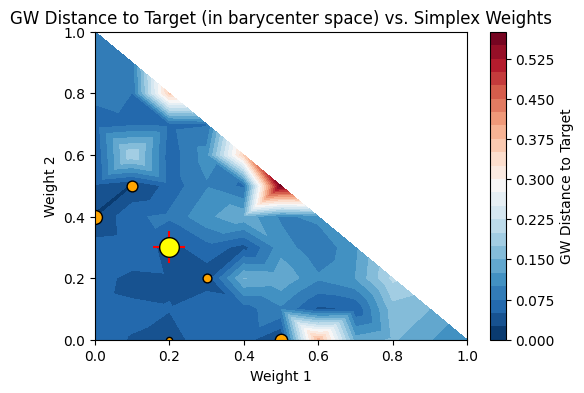

Real Barycentric Target found


  8%|▊         | 5/66 [00:00<00:01, 44.70it/s]

[np.float64(29.16193827168956), np.float64(0.0)]
[np.float64(28.154456069531335), np.float64(1.8287357919355882), np.float64(0.47318819571860954), np.float64(0.0)]
[np.float64(25.99423078383166), np.float64(3.9764288462977353), np.float64(1.817842896856239), np.float64(0.4840769241711791), np.float64(0.9334760709281005), np.float64(0.0)]
[np.float64(26.915587458684122), np.float64(2.628904825161174), np.float64(0.0)]
[np.float64(28.187570319368863), np.float64(1.1767376355253778), np.float64(0.8670465250425146), np.float64(1.349604608049112), np.float64(0.565279932206943), np.float64(3.309188501982946), np.float64(1.175187738302382), np.float64(1.8411622173656979), np.float64(0.8956301063812335), np.float64(0.0)]
[np.float64(24.319945134889185), np.float64(1.5703430881204723), np.float64(4.4534013646988875), np.float64(3.1002668970669074), np.float64(2.333404786594039), np.float64(0.7951749383789315), np.float64(0.0)]


 15%|█▌        | 10/66 [00:02<00:17,  3.15it/s]

[np.float64(27.988968763492704), np.float64(5.625409726746356), np.float64(1.1445125151682312), np.float64(3.1313195071331457), np.float64(6.120926157510453), np.float64(0.9139880927593548), np.float64(0.9202106624830739), np.float64(0.9202106624830739), np.float64(0.9202106624830739), np.float64(0.9202106624830739), np.float64(0.9202106624830739), np.float64(0.9202106624830739), np.float64(0.9202106624830739), np.float64(0.9202106624830739), np.float64(0.9202106624830739), np.float64(0.9202106624830739), np.float64(0.9202106624830739), np.float64(0.9202106624830739), np.float64(0.9202106624830739), np.float64(0.9202106624830739), np.float64(0.9202106624830739), np.float64(0.9202106624830739), np.float64(0.9202106624830739), np.float64(0.9202106624830739), np.float64(0.9202106624830739), np.float64(0.9202106624830739), np.float64(0.9202106624830739), np.float64(0.9202106624830739), np.float64(0.9202106624830739), np.float64(0.9202106624830739), np.float64(0.9202106624830739), np.float6

 18%|█▊        | 12/66 [00:05<00:31,  1.74it/s]

[np.float64(27.871995019007784), np.float64(5.521747366092827), np.float64(0.9494206995376063), np.float64(1.4973734046212615), np.float64(1.2318673984961261), np.float64(6.127976117207089), np.float64(1.2387242147975388), np.float64(1.225082936720435), np.float64(6.127976117207089), np.float64(1.2387242147975388), np.float64(1.225082936720435), np.float64(6.12797611720709), np.float64(1.2387242147975388), np.float64(1.225082936720435), np.float64(6.127976117207089), np.float64(1.2387242147975388), np.float64(1.225082936720435), np.float64(6.127976117207089), np.float64(1.2387242147975388), np.float64(1.225082936720435), np.float64(6.127976117207089), np.float64(1.2387242147975388), np.float64(1.225082936720435), np.float64(6.127976117207089), np.float64(1.2387242147975388), np.float64(1.225082936720435), np.float64(6.12797611720709), np.float64(1.2387242147975388), np.float64(1.225082936720435), np.float64(6.12797611720709), np.float64(1.2387242147975388), np.float64(1.225082936720435

 24%|██▍       | 16/66 [00:05<00:18,  2.75it/s]

[np.float64(27.817800851194786), np.float64(7.155625700014435), np.float64(4.880904725745748), np.float64(7.055306337282182), np.float64(4.648224265525588), np.float64(2.634080731716972), np.float64(1.3753101426607257), np.float64(0.8313625770320986), np.float64(3.1180835831180973), np.float64(5.989234581757952), np.float64(1.5016636852486434), np.float64(0.9451528068471481), np.float64(2.782437349016707), np.float64(3.7040366994744196), np.float64(1.238690874691317), np.float64(3.2800952127082414), np.float64(1.4489485834015012), np.float64(3.4388749324218626), np.float64(3.4556449781516703), np.float64(3.6565405826602837), np.float64(3.0499312752508376), np.float64(2.163545032776189), np.float64(3.9318671508994236), np.float64(2.6962780735631044), np.float64(4.976999130166474), np.float64(3.933891082813248), np.float64(7.309673599339159), np.float64(3.7365921532607014), np.float64(1.2745398027368264), np.float64(1.65905489681212), np.float64(3.2348270979058493), np.float64(5.38295051

 24%|██▍       | 16/66 [00:18<00:18,  2.75it/s]

[np.float64(26.89673050865293), np.float64(7.677508484079994), np.float64(2.6358885906274496), np.float64(2.395433521959809), np.float64(2.4040842121666435), np.float64(2.156400380706755), np.float64(2.3211570073705365), np.float64(2.128525776168719), np.float64(0.9556813066641432), np.float64(2.6959645054944334), np.float64(2.7205404377286944), np.float64(2.242977955674335), np.float64(2.469769325943973), np.float64(2.546697211699983), np.float64(2.299447600701568), np.float64(2.240073849261131), np.float64(2.469769325943973), np.float64(2.546697211699983), np.float64(2.299447600701568), np.float64(2.240073849261131), np.float64(2.469769325943973), np.float64(2.546697211699983), np.float64(2.299447600701568), np.float64(2.240073849261131), np.float64(2.469769325943973), np.float64(2.546697211699983), np.float64(2.299447600701568), np.float64(2.240073849261131), np.float64(2.469769325943973), np.float64(2.546697211699983), np.float64(2.299447600701568), np.float64(2.240073849261131), n

 27%|██▋       | 18/66 [00:28<02:17,  2.86s/it]

[np.float64(27.576891931917576), np.float64(2.2808373034944536), np.float64(2.8261292667156965), np.float64(2.4617902524677295), np.float64(2.2957861954499355), np.float64(2.4011011285722597), np.float64(2.386903049958132), np.float64(2.52374813921682), np.float64(2.430032703083356), np.float64(2.2284515441023163), np.float64(2.0888765649118897), np.float64(2.237104650064712), np.float64(2.4953854482116498), np.float64(2.488570545548364), np.float64(2.2837788061198725), np.float64(1.9582254123690361), np.float64(2.1886483606987186), np.float64(2.4218752951170477), np.float64(2.4466785629015333), np.float64(1.2523321422344371), np.float64(2.1085158919627127), np.float64(2.43434460201267), np.float64(2.3195111488462254), np.float64(2.1174717145472686), np.float64(1.3416782528357432), np.float64(2.7488124024871334), np.float64(2.4011718658713406), np.float64(1.4166981980613387), np.float64(2.336137631812345), np.float64(2.420262729949113), np.float64(2.0284166829599104), np.float64(2.0039

 35%|███▍      | 23/66 [00:30<01:09,  1.61s/it]

[np.float64(27.736564342734038), np.float64(1.481219652325718), np.float64(0.27440854774979306), np.float64(1.0499159527526871), np.float64(0.4953596929404451), np.float64(0.23326844426377363), np.float64(0.10107446671186995), np.float64(0.2626031401689259), np.float64(0.2300526656207686), np.float64(0.10107446671186995), np.float64(0.2626031401689259), np.float64(0.2300526656207686), np.float64(0.10107446671186995), np.float64(0.2626031401689259), np.float64(0.2300526656207686), np.float64(0.10107446671186995), np.float64(0.2626031401689259), np.float64(0.2300526656207686), np.float64(0.10107446671186995), np.float64(0.2626031401689259), np.float64(0.2300526656207686), np.float64(0.10107446671186995), np.float64(0.2626031401689259), np.float64(0.2300526656207686), np.float64(0.10107446671186995), np.float64(0.2626031401689259), np.float64(0.2300526656207686), np.float64(0.10107446671186995), np.float64(0.2626031401689259), np.float64(0.2300526656207686), np.float64(0.10107446671186995

 41%|████      | 27/66 [00:30<00:36,  1.08it/s]

[np.float64(27.945046303148278), np.float64(3.1327761047648814), np.float64(5.448313493129715), np.float64(3.7631888595402665), np.float64(3.829658872427729), np.float64(3.4680588300827697), np.float64(2.90727133894097), np.float64(2.4343506696084396), np.float64(3.3375886201431944), np.float64(9.469543408866937), np.float64(7.664324555275265), np.float64(2.1346212182827085), np.float64(4.429574456098592), np.float64(7.877350577374494), np.float64(10.324116685742927), np.float64(9.369768054882837), np.float64(6.463484460715899), np.float64(2.6970270230593005), np.float64(3.4303246065769626), np.float64(1.9013217478369835), np.float64(2.1350134915148447), np.float64(2.042019599136156), np.float64(3.0245871712646157), np.float64(3.2607622578372317), np.float64(0.8961497189496875), np.float64(0.0)]
[np.float64(27.41925028788029), np.float64(3.8838599782267034), np.float64(3.724560632994765), np.float64(2.109131708848863), np.float64(3.235277748443253), np.float64(2.4598967937171614), np.f

 50%|█████     | 33/66 [00:31<00:13,  2.49it/s]

[np.float64(28.00797757122377), np.float64(7.529174937374839), np.float64(4.173951274281451), np.float64(4.247431424280621), np.float64(3.9451412106844805), np.float64(3.1073598561844897), np.float64(1.8863350356891726), np.float64(2.2519971860331993), np.float64(2.2237625039437483), np.float64(0.15022965267383828), np.float64(2.3035043478413035), np.float64(1.1604332092458258), np.float64(1.7498550927173306), np.float64(0.6007226388119001), np.float64(0.07901968129988667), np.float64(1.2676206234054777), np.float64(1.9638675327048751), np.float64(2.294058435474971), np.float64(1.3239438380814406), np.float64(2.070885593682633), np.float64(0.9867222989162506), np.float64(0.10861140675493895), np.float64(0.0)]
[np.float64(26.172463881823884), np.float64(2.6144776317190934), np.float64(2.195274028765158), np.float64(4.733724306098607), np.float64(2.1476662081076254), np.float64(4.783687434006605), np.float64(4.832512051411986), np.float64(2.514922994312408), np.float64(0.579418788491072)

 55%|█████▍    | 36/66 [00:31<00:08,  3.41it/s]

[np.float64(27.06010871783469), np.float64(3.487369234749992), np.float64(3.9637110314696145), np.float64(4.616708960360693), np.float64(3.4774474436598584), np.float64(2.8906171480258362), np.float64(3.8258930476331097), np.float64(4.919841911991385), np.float64(4.869866612349884), np.float64(3.0588823718026257), np.float64(0.0)]
[np.float64(27.347336188248683), np.float64(5.653938277508662), np.float64(3.6782478048577953), np.float64(4.600717280984055), np.float64(5.987130175353892), np.float64(3.010386719752936), np.float64(6.3302485438206215), np.float64(2.920862441260932), np.float64(5.959221321148923), np.float64(5.462489754659452), np.float64(6.380172528028174), np.float64(6.132755600555325), np.float64(1.1758739178956623), np.float64(3.101027445547723), np.float64(0.7153378473281063), np.float64(0.1945245809520043), np.float64(0.0)]
[np.float64(28.576815248096647), np.float64(5.023082882318333), np.float64(3.5805589632491444), np.float64(2.4006665570576478), np.float64(2.802813

 61%|██████    | 40/66 [00:31<00:05,  5.14it/s]

[np.float64(28.276611650888174), np.float64(1.378422347248431), np.float64(1.400183964397534), np.float64(0.15467646451931863), np.float64(0.0)]
[np.float64(26.471559150473098), np.float64(10.978914695764391), np.float64(7.046040057077709), np.float64(1.9875449062952646), np.float64(3.944452975052683), np.float64(3.913340790195553), np.float64(1.421848055015158), np.float64(1.223229926942065), np.float64(2.2704730874092935), np.float64(4.628263315353992), np.float64(6.132757692928301), np.float64(5.582083358015951), np.float64(4.017598467292509), np.float64(4.878779968873566), np.float64(0.6299135383449249), np.float64(0.4710666101724523), np.float64(1.1066847751484912), np.float64(0.49052813122795075), np.float64(0.0)]
[np.float64(27.31758739938824), np.float64(5.432604992192633), np.float64(3.32144888889787), np.float64(1.2451127606591577), np.float64(2.094399555095874), np.float64(0.6400208384723832), np.float64(1.2998937901941297), np.float64(0.9200925608322343), np.float64(1.60059

 71%|███████   | 47/66 [00:34<00:04,  3.99it/s]

[np.float64(25.792297048361377), np.float64(7.0289996491656455), np.float64(1.6325176957011924), np.float64(4.154948448621084), np.float64(4.311618293585964), np.float64(1.2718101448418535), np.float64(4.010335025905369), np.float64(1.7195922175526956), np.float64(1.3630903809420498), np.float64(0.0)]
[np.float64(28.17784652508447), np.float64(7.4956652704832845), np.float64(0.7716010611540659), np.float64(0.25471801232583463), np.float64(0.0)]
[np.float64(25.16821641235458), np.float64(4.190330818780949), np.float64(5.398562535966123), np.float64(7.6698856984652615), np.float64(6.328720457260353), np.float64(5.40431973311456), np.float64(0.57178978832636), np.float64(0.5860746558277298), np.float64(1.1261185543649213), np.float64(0.0)]
[np.float64(26.39533587474009), np.float64(3.372030295528271), np.float64(4.390097798328089), np.float64(1.5644396780240453), np.float64(3.767468929223096), np.float64(0.23587806669450487), np.float64(0.0)]
[np.float64(28.54437113110915), np.float64(1.7

 76%|███████▌  | 50/66 [00:34<00:03,  4.93it/s]

[np.float64(26.192681094477308), np.float64(5.592014564707232), np.float64(1.2618624556198905), np.float64(1.360225599601792), np.float64(2.0774342273855075), np.float64(2.285022806547741), np.float64(2.3766476737527), np.float64(2.368019669536374), np.float64(2.2327687644891503), np.float64(2.1204657958904183), np.float64(2.555424008602103), np.float64(4.805021108888228), np.float64(4.124897042868152), np.float64(2.72978888445653), np.float64(4.396958415616795), np.float64(1.975762576244093), np.float64(5.235042498111524), np.float64(3.873929435098271), np.float64(1.966253595478955), np.float64(5.601484842425102), np.float64(7.193038893854726), np.float64(1.8913433337939953), np.float64(1.7875063006130791), np.float64(5.463220512780921), np.float64(2.06953616171345), np.float64(0.9404463907573386), np.float64(1.5386034864939149), np.float64(1.6746083536209342), np.float64(0.321659638021994), np.float64(0.0)]
[np.float64(28.161724412982515), np.float64(4.6375892487717465), np.float64(2

 86%|████████▋ | 57/66 [00:34<00:01,  8.50it/s]

[np.float64(26.72476638505472), np.float64(3.3788416838574684), np.float64(2.9447471465221735), np.float64(0.7268028497992779), np.float64(0.0)]
[np.float64(26.267602772729354), np.float64(3.6452154946380446), np.float64(4.308160391540168), np.float64(1.9421613321483133), np.float64(1.7738808362835146), np.float64(0.5934933634013609), np.float64(0.9793243964202955), np.float64(4.765657583973186), np.float64(5.254542548866015), np.float64(5.750659463868158), np.float64(3.6092993034780054), np.float64(4.512542622198879), np.float64(1.9343885681447122), np.float64(1.7442807785302483), np.float64(0.15803920468049976), np.float64(0.0)]
[np.float64(26.075828339251732), np.float64(2.760990660000367), np.float64(5.936344470047483), np.float64(3.8141479927570385), np.float64(3.4865348414844997), np.float64(1.202996914910123), np.float64(1.1422103446043221), np.float64(0.7014568184000581), np.float64(0.6159532264208446), np.float64(2.3297971173622223), np.float64(1.363102684772368), np.float64(1

 91%|█████████ | 60/66 [00:37<00:01,  3.08it/s]

[np.float64(27.859186291327074), np.float64(2.8519703203476356), np.float64(1.4657765229616857), np.float64(1.05628763320674), np.float64(0.44260478978018697), np.float64(0.26391162811722724), np.float64(0.3921641039709277), np.float64(2.495784924442348), np.float64(2.273332286197683), np.float64(1.6366093830399489), np.float64(6.02125271273016), np.float64(3.484815161715143), np.float64(1.3809399224407097), np.float64(1.5523882817240013), np.float64(0.5809023688610648), np.float64(0.6379834226007849), np.float64(0.4897967494008342), np.float64(0.6400615339375896), np.float64(0.5292025191718496), np.float64(0.1807171375307473), np.float64(0.6266905811826317), np.float64(0.4897967494008342), np.float64(0.6400615339375896), np.float64(0.5292025191718496), np.float64(0.1807171375307473), np.float64(0.6266905811826317), np.float64(0.4897967494008342), np.float64(0.6400615339375896), np.float64(0.5292025191718496), np.float64(0.1807171375307473), np.float64(0.6266905811826317), np.float64(0

100%|██████████| 66/66 [00:47<00:00,  1.38it/s]

[np.float64(27.4524277324434), np.float64(1.7511122481023356), np.float64(1.6387244444284716), np.float64(1.6442337878820064), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float6

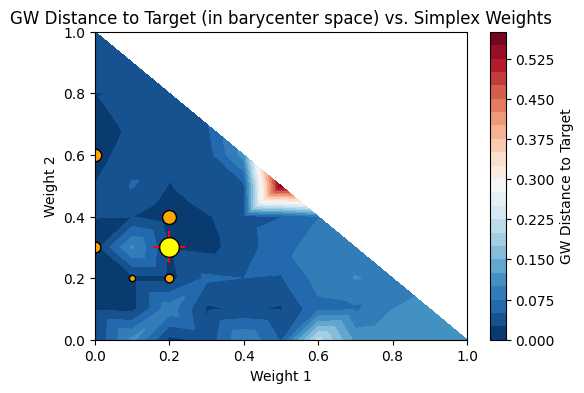

Real Barycentric Target found


  0%|          | 0/66 [00:00<?, ?it/s]

[np.float64(27.8834529610861), np.float64(0.0)]
[np.float64(27.43052791547), np.float64(0.7745892075531493), np.float64(0.0)]
[np.float64(27.385780483791443), np.float64(1.4922344490351092), np.float64(0.48407692417117887), np.float64(0.0)]


  6%|▌         | 4/66 [00:03<00:51,  1.21it/s]

[np.float64(26.70421143653799), np.float64(4.662771336579806), np.float64(6.642011355285354), np.float64(5.815087213824497), np.float64(5.347193771061952), np.float64(4.3674238656661615), np.float64(3.857476370295842), np.float64(3.7262108723344096), np.float64(0.04877773291483046), np.float64(0.04877773291483046), np.float64(0.04877773291483046), np.float64(0.04877773291483046), np.float64(0.04877773291483046), np.float64(0.04877773291483046), np.float64(0.04877773291483046), np.float64(0.04877773291483046), np.float64(0.04877773291483046), np.float64(0.04877773291483046), np.float64(0.04877773291483046), np.float64(0.04877773291483046), np.float64(0.04877773291483046), np.float64(0.04877773291483046), np.float64(0.04877773291483046), np.float64(0.04877773291483046), np.float64(0.04877773291483046), np.float64(0.04877773291483046), np.float64(0.04877773291483046), np.float64(0.04877773291483046), np.float64(0.04877773291483046), np.float64(0.04877773291483046), np.float64(0.0487777329

  9%|▉         | 6/66 [00:05<01:02,  1.04s/it]

[np.float64(25.86613079344384), np.float64(7.974728288612545), np.float64(0.986165974156643), np.float64(3.331158167329939), np.float64(3.669854251460216), np.float64(3.6544650627090567), np.float64(3.41402532021595), np.float64(3.267601481916466), np.float64(3.3017446538116966), np.float64(3.4445698143253716), np.float64(0.7954145773490019), np.float64(3.4254743133744956), np.float64(3.267601481916466), np.float64(3.3017446538116966), np.float64(3.4445698143253716), np.float64(0.7954145773490019), np.float64(3.4254743133744956), np.float64(3.267601481916466), np.float64(3.3017446538116966), np.float64(3.4445698143253716), np.float64(0.7954145773490019), np.float64(3.4254743133744956), np.float64(3.267601481916466), np.float64(3.3017446538116966), np.float64(3.4445698143253716), np.float64(0.7954145773490019), np.float64(3.4254743133744956), np.float64(3.267601481916466), np.float64(3.3017446538116966), np.float64(3.4445698143253716), np.float64(0.7954145773490019), np.float64(3.425474

 20%|█▉        | 13/66 [00:08<00:27,  1.93it/s]

[np.float64(26.537271489981464), np.float64(3.2887170177542564), np.float64(5.885715636750999), np.float64(2.062767768681208), np.float64(2.2287528552631786), np.float64(0.5636007512380429), np.float64(0.38332992158790624), np.float64(0.38332992158790624), np.float64(0.38332992158790624), np.float64(0.38332992158790624), np.float64(0.38332992158790624), np.float64(0.38332992158790624), np.float64(0.38332992158790624), np.float64(0.38332992158790624), np.float64(0.38332992158790624), np.float64(0.38332992158790624), np.float64(0.38332992158790624), np.float64(0.38332992158790624), np.float64(0.38332992158790624), np.float64(0.38332992158790624), np.float64(0.38332992158790624), np.float64(0.38332992158790624), np.float64(0.38332992158790624), np.float64(0.38332992158790624), np.float64(0.38332992158790624), np.float64(0.38332992158790624), np.float64(0.38332992158790624), np.float64(0.38332992158790624), np.float64(0.38332992158790624), np.float64(0.38332992158790624), np.float64(0.3833

 24%|██▍       | 16/66 [00:09<00:18,  2.72it/s]

[np.float64(27.794108483637313), np.float64(3.632096403795271), np.float64(4.28172529688041), np.float64(4.7345261691468465), np.float64(1.6915355264253655), np.float64(2.253661768252232), np.float64(1.1844437870032183), np.float64(1.2244950558209418), np.float64(0.6060937421125534), np.float64(0.0)]
[np.float64(27.248615695898028), np.float64(2.0796136076707024), np.float64(3.5348520547807367), np.float64(2.9962259410703105), np.float64(1.2561451991348838), np.float64(1.1503800139489697), np.float64(3.106170200109908), np.float64(1.163692865408495), np.float64(4.434890800936684), np.float64(4.071707911913045), np.float64(1.5916386455693248), np.float64(3.867258762713661), np.float64(1.751884988301798), np.float64(3.984796562287783), np.float64(3.460028569501244), np.float64(3.6439584066631223), np.float64(3.669866995888929), np.float64(3.5353533801467476), np.float64(1.6048598237694032), np.float64(4.713136182828423), np.float64(3.172054683556614), np.float64(1.7044727734758776), np.f

 27%|██▋       | 18/66 [00:14<00:44,  1.07it/s]

[np.float64(26.095774184263703), np.float64(7.070805609061714), np.float64(2.429512630712558), np.float64(2.4565806583417533), np.float64(2.3537948335360777), np.float64(2.0154282063162254), np.float64(1.8844723299591222), np.float64(2.03877688551815), np.float64(2.660254441359527), np.float64(2.557737475725539), np.float64(1.9642733244337836), np.float64(1.9921090730926518), np.float64(2.017870934888351), np.float64(2.304163670855214), np.float64(2.2851882404199553), np.float64(2.2851882404199553), np.float64(2.2851882404199553), np.float64(2.2851882404199553), np.float64(2.2851882404199553), np.float64(2.2851882404199553), np.float64(2.2851882404199553), np.float64(2.2851882404199553), np.float64(2.2851882404199553), np.float64(2.2851882404199553), np.float64(2.2851882404199553), np.float64(2.2851882404199553), np.float64(2.2851882404199553), np.float64(2.2851882404199553), np.float64(2.2851882404199553), np.float64(2.2851882404199553), np.float64(2.2851882404199553), np.float64(2.28

 35%|███▍      | 23/66 [00:14<00:22,  1.92it/s]

[np.float64(27.28393603019074), np.float64(6.1516719715464365), np.float64(3.5872541035852734), np.float64(2.3860560305897254), np.float64(2.5167970830352484), np.float64(4.865767645416709), np.float64(4.300301471574074), np.float64(5.040641186790866), np.float64(2.4716998630547597), np.float64(2.2887050213233233), np.float64(2.559737312387491), np.float64(4.293600305994197), np.float64(4.025211453085493), np.float64(4.156302074722678), np.float64(3.2330535895738826), np.float64(1.644609301879398), np.float64(1.821391012803445), np.float64(0.6814442298462102), np.float64(2.1035651872908665), np.float64(2.741244597069633), np.float64(3.9816084256476367), np.float64(4.991446414475727), np.float64(3.7128267771713745), np.float64(4.886842157676506), np.float64(4.703004899134552), np.float64(3.32943562878375), np.float64(1.577298523438132), np.float64(2.817818988212201), np.float64(1.9659171622965144), np.float64(0.0)]
[np.float64(25.404435685363367), np.float64(2.8433930181243783), np.floa

 41%|████      | 27/66 [00:22<00:36,  1.06it/s]

[np.float64(27.66931189096397), np.float64(6.112406213420959), np.float64(4.82162119669654), np.float64(4.660284971942069), np.float64(3.021190406632377), np.float64(11.320234113735404), np.float64(2.9244338400471697), np.float64(2.3775061205911174), np.float64(2.103919818550528), np.float64(2.138494121596559), np.float64(2.5997946810591013), np.float64(2.577173767102199), np.float64(2.2596537762566467), np.float64(1.9896907713920562), np.float64(1.521212492344818), np.float64(4.022695032438695), np.float64(4.2355856983820495), np.float64(4.553217435838077), np.float64(5.035306841863461), np.float64(2.5270539310666202), np.float64(3.3675874796891017), np.float64(4.371992031921232), np.float64(4.855971751241826), np.float64(2.3633709045965046), np.float64(3.693618202360583), np.float64(2.051380937887275), np.float64(1.9186827669690245), np.float64(2.5036444146699552), np.float64(1.4468312602957278), np.float64(1.1588626559841044), np.float64(1.128460267929975), np.float64(1.128460267929

 48%|████▊     | 32/66 [00:22<00:16,  2.03it/s]

[np.float64(28.698600221232674), np.float64(1.6197234412615578), np.float64(3.3621008125608145), np.float64(3.298492200978493), np.float64(2.9750282603400406), np.float64(3.070827917438059), np.float64(4.166010667717941), np.float64(4.316571886649632), np.float64(4.648103228207377), np.float64(1.3830767488157072), np.float64(2.512549654778243), np.float64(4.119815498722471), np.float64(2.3172425636664187), np.float64(1.6035876452189448), np.float64(1.646849387946068), np.float64(4.400867530078584), np.float64(4.021867403304847), np.float64(4.212482911073205), np.float64(1.7989298141564907), np.float64(2.322245539344561), np.float64(1.6617673959533084), np.float64(2.179242592092462), np.float64(1.7701669009292629), np.float64(2.4958248712348765), np.float64(1.67851916342189), np.float64(2.5906854210769654), np.float64(1.8234298945113188), np.float64(1.7770746704353346), np.float64(4.549459530931471), np.float64(4.321375804715132), np.float64(2.78736154461128), np.float64(1.7318782371118

 52%|█████▏    | 34/66 [00:25<00:23,  1.39it/s]

[np.float64(25.13439666977498), np.float64(5.86790898211116), np.float64(6.00524583813179), np.float64(6.117636427243161), np.float64(2.9043214391329712), np.float64(6.359281172738545), np.float64(4.1916750377252745), np.float64(2.0922611898998484), np.float64(0.6542572726050795), np.float64(0.1288970537660987), np.float64(0.1288970537660987), np.float64(0.1288970537660987), np.float64(0.1288970537660987), np.float64(0.1288970537660987), np.float64(0.1288970537660987), np.float64(0.1288970537660987), np.float64(0.1288970537660987), np.float64(0.1288970537660987), np.float64(0.1288970537660987), np.float64(0.1288970537660987), np.float64(0.1288970537660987), np.float64(0.1288970537660987), np.float64(0.1288970537660987), np.float64(0.1288970537660987), np.float64(0.1288970537660987), np.float64(0.1288970537660987), np.float64(0.1288970537660987), np.float64(0.1288970537660987), np.float64(0.1288970537660987), np.float64(0.1288970537660987), np.float64(0.1288970537660987), np.float64(0.1

 55%|█████▍    | 36/66 [00:31<00:38,  1.28s/it]

[np.float64(28.293209309975847), np.float64(3.564713462012845), np.float64(1.8829546333315412), np.float64(2.389619781199262), np.float64(2.07220413333105), np.float64(2.1976248900471536), np.float64(4.299897903858675), np.float64(4.8682764812796835), np.float64(2.4164623353606447), np.float64(2.7141398921563638), np.float64(5.095944429908077), np.float64(5.11724257357004), np.float64(5.900469342877333), np.float64(2.7180808415520143), np.float64(4.695059604339401), np.float64(4.451962139278099), np.float64(3.526538859120607), np.float64(4.506599698268814), np.float64(4.024235715930465), np.float64(3.4936932431669145), np.float64(3.40143918845539), np.float64(3.294815621276544), np.float64(3.35822105763937), np.float64(3.140837610840752), np.float64(3.6598995494801363), np.float64(8.350357664552211), np.float64(7.212200501705561), np.float64(5.5009492626723), np.float64(3.1079308648241613), np.float64(6.94098341427516), np.float64(6.490047997136479), np.float64(1.4928666479689543), np.

 62%|██████▏   | 41/66 [00:31<00:16,  1.56it/s]

[np.float64(28.15084167321965), np.float64(4.442502591974283), np.float64(0.4748794272042149), np.float64(1.5837291926948525), np.float64(1.6484187248860775), np.float64(1.1296271673061389), np.float64(0.0)]
[np.float64(26.0470031383731), np.float64(3.287826765955877), np.float64(3.3858316969541415), np.float64(1.3544663601913522), np.float64(0.0)]
[np.float64(28.092419056402015), np.float64(6.039770638875465), np.float64(3.2008799082459776), np.float64(5.274380922473028), np.float64(4.223580686721393), np.float64(2.170843271719548), np.float64(1.8223480272349803), np.float64(1.1157045696369523), np.float64(0.3584965967324334), np.float64(1.0054051135281825), np.float64(0.21417634963378787), np.float64(0.07258380135300416), np.float64(0.0)]
[np.float64(26.325862565214162), np.float64(1.4314816807387927), np.float64(2.171550231481929), np.float64(2.9883314493165423), np.float64(3.176629570429044), np.float64(4.230498509296451), np.float64(1.8433576968092498), np.float64(1.81850730054799

 71%|███████   | 47/66 [00:34<00:09,  2.11it/s]

[np.float64(26.835699042767036), np.float64(5.480080302294508), np.float64(1.708941558607418), np.float64(3.5613537025633644), np.float64(1.744896563237466), np.float64(1.922868088612196), np.float64(1.8057527317704158), np.float64(1.8057527317704158), np.float64(1.8057527317704158), np.float64(1.8057527317704158), np.float64(1.8057527317704158), np.float64(1.8057527317704158), np.float64(1.8057527317704158), np.float64(1.8057527317704158), np.float64(1.8057527317704158), np.float64(1.8057527317704158), np.float64(1.8057527317704158), np.float64(1.8057527317704158), np.float64(1.8057527317704158), np.float64(1.8057527317704158), np.float64(1.8057527317704158), np.float64(1.8057527317704158), np.float64(1.8057527317704158), np.float64(1.8057527317704158), np.float64(1.8057527317704158), np.float64(1.8057527317704158), np.float64(1.8057527317704158), np.float64(1.8057527317704158), np.float64(1.8057527317704158), np.float64(1.8057527317704158), np.float64(1.8057527317704158), np.float64(

 74%|███████▍  | 49/66 [00:36<00:11,  1.49it/s]

[np.float64(28.77385543740596), np.float64(5.203094425351376), np.float64(9.986115313355816), np.float64(5.957944879255417), np.float64(2.5520465523692577), np.float64(1.2173099721863485), np.float64(6.284353182380128), np.float64(1.24336179946993), np.float64(6.604612594124222), np.float64(0.6536047262841699), np.float64(2.3881579196290303), np.float64(4.1971634750471525), np.float64(5.0624504567337985), np.float64(3.7880939629850974), np.float64(2.231841003168884), np.float64(3.6355900701407577), np.float64(2.4526310547306207), np.float64(4.973475870792277), np.float64(3.3600493360622736), np.float64(2.9701153959705704), np.float64(2.2024918277544625), np.float64(1.4864867229010226), np.float64(0.6886270615824236), np.float64(0.11852952194983116), np.float64(6.122231161586894), np.float64(2.8802575453864074), np.float64(0.8877698249176948), np.float64(0.6147562434812044), np.float64(6.394810767061197), np.float64(1.7318044697297392), np.float64(1.5384536967296352), np.float64(6.11270

 82%|████████▏ | 54/66 [00:37<00:04,  2.85it/s]

[np.float64(26.180647382562743), np.float64(5.020922702957704), np.float64(4.3842208024677705), np.float64(0.6692662422953476), np.float64(0.8253094162492072), np.float64(0.3266977326097127), np.float64(3.4165592211565943), np.float64(0.43390135768309457), np.float64(4.343678564623141), np.float64(4.230125487013884), np.float64(3.782228565849066), np.float64(5.19415242431888), np.float64(3.655187240039255), np.float64(2.964949748606849), np.float64(2.7527127852240754), np.float64(1.8523707249615966), np.float64(1.3159003651905699), np.float64(1.087441295153541), np.float64(0.9237709705468733), np.float64(1.3567767016826584), np.float64(1.7136127231603455), np.float64(0.5435802892012518), np.float64(5.684181099488091), np.float64(0.6799478761255789), np.float64(0.21240170289950583), np.float64(0.0)]
[np.float64(27.120272711964358), np.float64(1.0957155418079865), np.float64(0.9409287309655374), np.float64(0.0)]
[np.float64(26.81598209569609), np.float64(4.477319791840914), np.float64(3.

 89%|████████▉ | 59/66 [00:37<00:01,  4.93it/s]

[np.float64(27.421670081383166), np.float64(4.291609561028215), np.float64(3.272875065896095), np.float64(2.1233797824634135), np.float64(0.9851755893616879), np.float64(0.051725299291852066), np.float64(0.0)]
[np.float64(28.526888294739603), np.float64(3.7544462754662282), np.float64(1.0773047502844242), np.float64(0.0)]
[np.float64(27.314706254626433), np.float64(1.359102481645834), np.float64(1.868931320048019), np.float64(4.132362889460693), np.float64(7.888843271822614), np.float64(5.216338511527808), np.float64(0.41658961725743154), np.float64(0.24068949722307506), np.float64(0.0)]
[np.float64(25.466210883709152), np.float64(1.8961557473763389), np.float64(1.3793951073538713), np.float64(1.711179357497646), np.float64(2.2072599220529177), np.float64(1.8223583672768813), np.float64(3.8725677392471787), np.float64(2.5423763796059657), np.float64(3.6305927676025678), np.float64(4.888215109342031), np.float64(2.221088948174267), np.float64(0.9164301453557279), np.float64(0.4235941786

 92%|█████████▏| 61/66 [00:40<00:02,  1.96it/s]

[np.float64(26.539016218372172), np.float64(1.760983259412656), np.float64(2.6331370935749794), np.float64(2.6316707473137515), np.float64(2.9404008338583285), np.float64(1.5894718670981463), np.float64(0.3023108540851987), np.float64(1.4737447019852352), np.float64(1.4737447019852352), np.float64(1.4737447019852352), np.float64(1.4737447019852352), np.float64(1.4737447019852352), np.float64(1.4737447019852352), np.float64(1.4737447019852352), np.float64(1.4737447019852352), np.float64(1.4737447019852352), np.float64(1.4737447019852352), np.float64(1.4737447019852352), np.float64(1.4737447019852352), np.float64(1.4737447019852352), np.float64(1.4737447019852352), np.float64(1.4737447019852352), np.float64(1.4737447019852352), np.float64(1.4737447019852352), np.float64(1.4737447019852352), np.float64(1.4737447019852352), np.float64(1.4737447019852352), np.float64(1.4737447019852352), np.float64(1.4737447019852352), np.float64(1.4737447019852352), np.float64(1.4737447019852352), np.float

100%|██████████| 66/66 [00:50<00:00,  1.30it/s]

[np.float64(26.63273849188465), np.float64(2.286651557179922), np.float64(0.738034411480786), np.float64(1.2702191044691957), np.float64(1.7232029602161651), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64

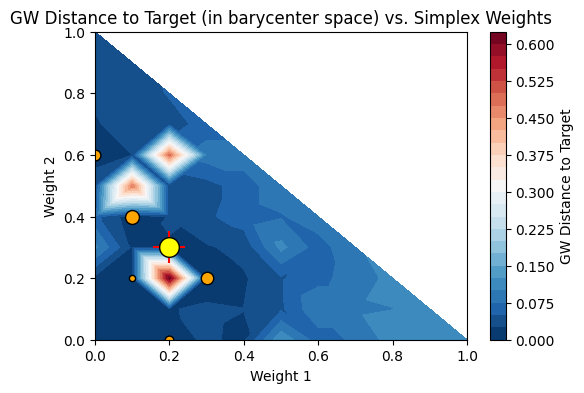

Real Barycentric Target found


  0%|          | 0/66 [00:00<?, ?it/s]

[np.float64(26.669046600009185), np.float64(0.0)]


  3%|▎         | 2/66 [00:02<01:13,  1.15s/it]

[np.float64(26.98853642162032), np.float64(1.9309037571695), np.float64(0.47593821319715357), np.float64(0.47593821319715357), np.float64(0.47593821319715357), np.float64(0.47593821319715357), np.float64(0.47593821319715357), np.float64(0.47593821319715357), np.float64(0.47593821319715357), np.float64(0.47593821319715357), np.float64(0.47593821319715357), np.float64(0.47593821319715357), np.float64(0.47593821319715357), np.float64(0.47593821319715357), np.float64(0.47593821319715357), np.float64(0.47593821319715357), np.float64(0.47593821319715357), np.float64(0.47593821319715357), np.float64(0.47593821319715357), np.float64(0.47593821319715357), np.float64(0.47593821319715357), np.float64(0.47593821319715357), np.float64(0.47593821319715357), np.float64(0.47593821319715357), np.float64(0.47593821319715357), np.float64(0.47593821319715357), np.float64(0.47593821319715357), np.float64(0.47593821319715357), np.float64(0.47593821319715357), np.float64(0.47593821319715357), np.float64(0.47

  6%|▌         | 4/66 [00:04<01:11,  1.16s/it]

[np.float64(27.423319669872384), np.float64(2.7090619978496577), np.float64(0.16614380086396843), np.float64(0.16614380086396843), np.float64(0.16614380086396843), np.float64(0.16614380086396843), np.float64(0.16614380086396843), np.float64(0.16614380086396843), np.float64(0.16614380086396843), np.float64(0.16614380086396843), np.float64(0.16614380086396843), np.float64(0.16614380086396843), np.float64(0.16614380086396843), np.float64(0.16614380086396843), np.float64(0.16614380086396843), np.float64(0.16614380086396843), np.float64(0.16614380086396843), np.float64(0.16614380086396843), np.float64(0.16614380086396843), np.float64(0.16614380086396843), np.float64(0.16614380086396843), np.float64(0.16614380086396843), np.float64(0.16614380086396843), np.float64(0.16614380086396843), np.float64(0.16614380086396843), np.float64(0.16614380086396843), np.float64(0.16614380086396843), np.float64(0.16614380086396843), np.float64(0.16614380086396843), np.float64(0.16614380086396843), np.float64(

 17%|█▋        | 11/66 [00:07<00:28,  1.94it/s]

[np.float64(27.970507050164116), np.float64(1.7566505664895937), np.float64(3.444517321681388), np.float64(3.2979574144897352), np.float64(3.6960078633945095), np.float64(3.378201882989188), np.float64(3.4039325268063116), np.float64(3.410344858631622), np.float64(3.410344858631622), np.float64(3.410344858631622), np.float64(3.410344858631622), np.float64(3.410344858631622), np.float64(3.410344858631622), np.float64(3.410344858631622), np.float64(3.410344858631622), np.float64(3.410344858631622), np.float64(3.410344858631622), np.float64(3.410344858631622), np.float64(3.410344858631622), np.float64(3.410344858631622), np.float64(3.410344858631622), np.float64(3.410344858631622), np.float64(3.410344858631622), np.float64(3.410344858631622), np.float64(3.410344858631622), np.float64(3.410344858631622), np.float64(3.410344858631622), np.float64(3.410344858631622), np.float64(3.410344858631622), np.float64(3.410344858631622), np.float64(3.410344858631622), np.float64(3.410344858631622), np

 21%|██        | 14/66 [00:07<00:18,  2.87it/s]

[np.float64(27.434516201589275), np.float64(2.4229977854427243), np.float64(17.356931463484933), np.float64(3.090999465343209), np.float64(1.5253343614587112), np.float64(0.6572649668034952), np.float64(0.3118767671442403), np.float64(1.0907246235911177), np.float64(1.8331640380773961), np.float64(1.7331649285077595), np.float64(2.7962438423436167), np.float64(1.021347410337767), np.float64(1.833348133426961), np.float64(1.939315755706809), np.float64(1.5811210491325547), np.float64(0.33965718305597553), np.float64(0.0)]
[np.float64(25.42436903584448), np.float64(2.9964370326464), np.float64(1.2341629473548044), np.float64(1.3343367542232039), np.float64(0.5257744917579773), np.float64(0.0)]
[np.float64(26.849377268213907), np.float64(3.0454165983312014), np.float64(2.7250259059549173), np.float64(0.8609180925177496), np.float64(1.174483683682102), np.float64(4.263465064828696), np.float64(2.4023183486219213), np.float64(4.441321696334434), np.float64(2.1721270788740616), np.float64(0.

 26%|██▌       | 17/66 [00:13<00:42,  1.16it/s]

[np.float64(28.763415882343995), np.float64(3.3512789958169993), np.float64(2.8587368900167442), np.float64(1.4293110211860012), np.float64(3.1144968011381207), np.float64(1.3202425588994835), np.float64(1.2540967710022584), np.float64(1.195881177045077), np.float64(1.2177881995940447), np.float64(1.1907950494903417), np.float64(1.1907950494903417), np.float64(1.1907950494903417), np.float64(1.1907950494903417), np.float64(1.1907950494903417), np.float64(1.1907950494903417), np.float64(1.1907950494903417), np.float64(1.1907950494903417), np.float64(1.1907950494903417), np.float64(1.1907950494903417), np.float64(1.1907950494903417), np.float64(1.1907950494903417), np.float64(1.1907950494903417), np.float64(1.1907950494903417), np.float64(1.1907950494903417), np.float64(1.1907950494903417), np.float64(1.1907950494903417), np.float64(1.1907950494903417), np.float64(1.1907950494903417), np.float64(1.1907950494903417), np.float64(1.1907950494903417), np.float64(1.1907950494903417), np.float

 29%|██▉       | 19/66 [00:27<01:47,  2.29s/it]

[np.float64(26.972151632224286), np.float64(3.342509420558677), np.float64(5.520154054718232), np.float64(0.9954879980992114), np.float64(2.8400530511749063), np.float64(2.805115475953352), np.float64(2.251326194995565), np.float64(2.0611601147102387), np.float64(2.660254441359527), np.float64(2.557737475725539), np.float64(1.9642733244337836), np.float64(1.9921090730926518), np.float64(2.017870934888351), np.float64(2.304163670855214), np.float64(2.2851882404199553), np.float64(2.2851882404199553), np.float64(2.2851882404199553), np.float64(2.2851882404199553), np.float64(2.2851882404199553), np.float64(2.2851882404199553), np.float64(2.2851882404199553), np.float64(2.2851882404199553), np.float64(2.2851882404199553), np.float64(2.2851882404199553), np.float64(2.2851882404199553), np.float64(2.2851882404199553), np.float64(2.2851882404199553), np.float64(2.2851882404199553), np.float64(2.2851882404199553), np.float64(2.2851882404199553), np.float64(2.2851882404199553), np.float64(2.28

 30%|███       | 20/66 [00:29<01:46,  2.32s/it]

[np.float64(27.56252866598675), np.float64(1.9309957217798432), np.float64(1.2828104704724812), np.float64(0.6656971291971089), np.float64(0.6258955089622077), np.float64(0.8002565550873658), np.float64(0.609446883616101), np.float64(0.6249274329116705), np.float64(0.28838229814442184), np.float64(0.7403641493725627), np.float64(0.6492781312136802), np.float64(0.6249274329116705), np.float64(0.28838229814442184), np.float64(0.7403641493725627), np.float64(0.6492781312136802), np.float64(0.6249274329116705), np.float64(0.28838229814442184), np.float64(0.7403641493725627), np.float64(0.6492781312136802), np.float64(0.6249274329116705), np.float64(0.28838229814442184), np.float64(0.7403641493725627), np.float64(0.6492781312136802), np.float64(0.6249274329116705), np.float64(0.28838229814442184), np.float64(0.7403641493725627), np.float64(0.6492781312136802), np.float64(0.6249274329116705), np.float64(0.28838229814442184), np.float64(0.7403641493725627), np.float64(0.6492781312136802), np.

 38%|███▊      | 25/66 [00:33<00:58,  1.42s/it]

[np.float64(27.289533018534947), np.float64(3.261133463074782), np.float64(4.650025902577215), np.float64(3.3130011407959623), np.float64(2.813447291142084), np.float64(5.047422516035957), np.float64(2.3513601121528485), np.float64(1.201593445782096), np.float64(0.543962381138406), np.float64(0.543962381138406), np.float64(0.543962381138406), np.float64(0.543962381138406), np.float64(0.543962381138406), np.float64(0.543962381138406), np.float64(0.543962381138406), np.float64(0.543962381138406), np.float64(0.543962381138406), np.float64(0.543962381138406), np.float64(0.543962381138406), np.float64(0.543962381138406), np.float64(0.543962381138406), np.float64(0.543962381138406), np.float64(0.543962381138406), np.float64(0.543962381138406), np.float64(0.543962381138406), np.float64(0.543962381138406), np.float64(0.543962381138406), np.float64(0.543962381138406), np.float64(0.543962381138406), np.float64(0.543962381138406), np.float64(0.543962381138406), np.float64(0.543962381138406), np.f

 48%|████▊     | 32/66 [00:33<00:18,  1.84it/s]

[np.float64(26.395008951754615), np.float64(5.3566461654371), np.float64(3.709560886246298), np.float64(2.373489802521762), np.float64(1.4511396176686868), np.float64(1.405668780879656), np.float64(0.7487640033039489), np.float64(0.5738694952930268), np.float64(0.37198671740643324), np.float64(0.0)]
[np.float64(27.439265865562774), np.float64(5.350327616161984), np.float64(2.744756093682646), np.float64(1.3560219596609981), np.float64(2.1279253799184152), np.float64(2.190501021064473), np.float64(2.2755752499425217), np.float64(1.718144781750184), np.float64(1.7578774609423824), np.float64(1.6684349037671369), np.float64(0.6770786626677721), np.float64(2.245890517039266), np.float64(3.1140220961121234), np.float64(3.8588720367897515), np.float64(4.496540620066851), np.float64(2.4815427009344546), np.float64(2.6254428528994067), np.float64(1.664567319173155), np.float64(2.4459408418949833), np.float64(2.2058737551306913), np.float64(1.3357289348848653), np.float64(1.8707071808727151), n

 52%|█████▏    | 34/66 [00:33<00:14,  2.25it/s]

[np.float64(25.948485667838895), np.float64(3.997521312577675), np.float64(1.713454197127767), np.float64(1.4814333375479034), np.float64(3.7266754784196876), np.float64(3.6921608652284132), np.float64(3.5642443321198662), np.float64(3.880506973921143), np.float64(4.284790434144682), np.float64(2.1653833393834296), np.float64(0.9574999846690919), np.float64(0.5758723409081858), np.float64(0.5124286039582888), np.float64(0.0)]
[np.float64(27.04415095128717), np.float64(5.048195327921655), np.float64(3.5911080346466466), np.float64(3.3481947156642313), np.float64(8.355446807434932), np.float64(5.637695050842243), np.float64(5.211749857850041), np.float64(5.204062922715201), np.float64(7.0838128975528365), np.float64(3.094440240829116), np.float64(2.2318460034018957), np.float64(2.5861205677350743), np.float64(1.321882687493329), np.float64(0.7638922719941271), np.float64(4.756983213031054), np.float64(6.1113616414912135), np.float64(7.093100697529574), np.float64(2.9194609848016557), np.

 55%|█████▍    | 36/66 [00:33<00:10,  2.73it/s]

[np.float64(27.662269793008583), np.float64(7.625953242426446), np.float64(8.03346295715956), np.float64(3.613065282763585), np.float64(2.056226010038914), np.float64(2.882244111206435), np.float64(2.4270635837301184), np.float64(1.4465150706721552), np.float64(3.325102483545891), np.float64(3.616604865139352), np.float64(8.27520452001743), np.float64(4.5365786321808645), np.float64(8.42358889780672), np.float64(4.070205927746862), np.float64(3.8807739793987506), np.float64(7.808581670023965), np.float64(0.7733074052882125), np.float64(0.3159727492234024), np.float64(0.0)]
[np.float64(26.511533276739783), np.float64(6.116378123589945), np.float64(3.382909836991187), np.float64(3.9787852786672517), np.float64(5.647709133645245), np.float64(1.8919618716033821), np.float64(1.7927895364111304), np.float64(3.7905819813362127), np.float64(1.5599212906722164), np.float64(3.3766240487691075), np.float64(6.747889568858785), np.float64(4.97598886180628), np.float64(5.718442548034371), np.float64

 61%|██████    | 40/66 [00:33<00:05,  4.35it/s]

[np.float64(26.453343525656894), np.float64(4.7783717727295505), np.float64(2.0706187128446714), np.float64(2.575596458128025), np.float64(2.4964208324931603), np.float64(0.4144105150933187), np.float64(3.0842365771890727), np.float64(2.778609963399623), np.float64(1.003831729014496), np.float64(2.894382099804709), np.float64(2.3941151821721793), np.float64(2.325052530402447), np.float64(3.1427719121126483), np.float64(2.2110937181360137), np.float64(0.5214175395081719), np.float64(0.0)]
[np.float64(28.62445410717876), np.float64(1.8353633591583647), np.float64(0.0)]
[np.float64(28.37758457218592), np.float64(4.097147964573273), np.float64(1.06691712559024), np.float64(0.0)]
[np.float64(26.99216777352105), np.float64(1.932177240367039), np.float64(2.934670343232283), np.float64(5.227273252730534), np.float64(1.4601909594061653), np.float64(0.9140945223598768), np.float64(5.809258180290817), np.float64(1.185971957820124), np.float64(3.3264252549275883), np.float64(12.894303462356289), n

 64%|██████▎   | 42/66 [00:39<00:19,  1.26it/s]

[np.float64(27.45685072370619), np.float64(8.42828289871574), np.float64(2.510117693960396), np.float64(4.454460471016596), np.float64(2.924266853732521), np.float64(4.447965971671697), np.float64(4.436229037967867), np.float64(4.057637389555784), np.float64(4.291846230115363), np.float64(3.1101331034918465), np.float64(4.273077103868145), np.float64(4.5622870898551575), np.float64(2.278798496279314), np.float64(3.8910243938046243), np.float64(4.624183927682076), np.float64(4.322111192955795), np.float64(5.593728422059929), np.float64(5.512546835252508), np.float64(3.2734229431559867), np.float64(3.09059284254336), np.float64(4.143764624700099), np.float64(5.70253368269539), np.float64(3.965367006649745), np.float64(6.74851984487273), np.float64(5.9923792362108825), np.float64(2.402449500028302), np.float64(1.349746676127812), np.float64(0.8921820710942961), np.float64(0.9030030895803738), np.float64(3.3658136905408513), np.float64(4.536915031659614), np.float64(3.091687898284704), np.

 73%|███████▎  | 48/66 [00:44<00:12,  1.39it/s]

[np.float64(27.146505658272158), np.float64(2.204671649303153), np.float64(4.340743893753138), np.float64(2.337062076334697), np.float64(0.43434960291352925), np.float64(0.7551408984419807), np.float64(0.23320640421508032), np.float64(0.7196889681430717), np.float64(4.004804541977167), np.float64(2.10575212987258), np.float64(0.3783320798170204), np.float64(0.3925180669913544), np.float64(0.3861161353432611), np.float64(0.21240170289950594), np.float64(0.3925180669913544), np.float64(0.3861161353432611), np.float64(0.21240170289950594), np.float64(0.3925180669913544), np.float64(0.3861161353432611), np.float64(0.21240170289950594), np.float64(0.3925180669913544), np.float64(0.3861161353432611), np.float64(0.21240170289950594), np.float64(0.3925180669913544), np.float64(0.3861161353432611), np.float64(0.21240170289950594), np.float64(0.3925180669913544), np.float64(0.3861161353432611), np.float64(0.21240170289950594), np.float64(0.3925180669913544), np.float64(0.3861161353432611), np.fl

 79%|███████▉  | 52/66 [00:44<00:06,  2.15it/s]

[np.float64(28.09858535669883), np.float64(7.9726899623680385), np.float64(5.1664279423714525), np.float64(1.6745739310594725), np.float64(1.035747980137825), np.float64(2.5916740088641435), np.float64(1.0267869233111646), np.float64(3.783584315599177), np.float64(0.8238774985301729), np.float64(5.166056884686965), np.float64(0.9905496700030436), np.float64(0.3128856418433683), np.float64(0.49659842353049866), np.float64(0.0)]
[np.float64(26.492715993663804), np.float64(6.616767313836019), np.float64(1.1852988914103697), np.float64(0.6832566967836601), np.float64(0.0)]
[np.float64(27.43456957089538), np.float64(8.556783193044955), np.float64(4.606100430468675), np.float64(5.36543773033298), np.float64(0.6276531477541262), np.float64(0.0)]
[np.float64(26.607322712677387), np.float64(8.444744975525975), np.float64(1.1469344508135395), np.float64(1.05074669933829), np.float64(0.0)]
[np.float64(26.63366127371028), np.float64(4.730771514315684), np.float64(1.7882851284876702), np.float64(5.

 83%|████████▎ | 55/66 [00:52<00:11,  1.05s/it]

[np.float64(26.35268371341284), np.float64(3.3239013591619515), np.float64(4.717098553279204), np.float64(1.7951360699600447), np.float64(1.932774610605487), np.float64(1.9806455287137392), np.float64(0.947627987768977), np.float64(6.338904376340486), np.float64(2.5864001836768655), np.float64(3.3417482743725975), np.float64(2.3291674304894436), np.float64(2.679740212213415), np.float64(1.6224150634168677), np.float64(2.008456394843357), np.float64(2.2004050293170025), np.float64(1.6418737115464195), np.float64(0.5499257176333412), np.float64(1.5427917205874975), np.float64(4.984619595592011), np.float64(2.929230686260231), np.float64(2.0121675119766578), np.float64(3.3069105654073216), np.float64(1.4972109001902865), np.float64(1.8377702230032056), np.float64(2.118649159158897), np.float64(1.4510896571148062), np.float64(0.0854514236015928), np.float64(1.0330957877085665), np.float64(1.4815722385875632), np.float64(4.282312912949352), np.float64(3.4036913994896114), np.float64(3.23323

 89%|████████▉ | 59/66 [00:54<00:06,  1.10it/s]

[np.float64(29.054628053304814), np.float64(2.830333303073094), np.float64(2.316966842145323), np.float64(0.41099246954697527), np.float64(0.750527215772909), np.float64(2.149192973597569), np.float64(1.0299850766596133), np.float64(1.6514034210166353), np.float64(1.7265363606273518), np.float64(1.8255582922873372), np.float64(0.6038463678908951), np.float64(1.6280035686599212), np.float64(0.42961479917360695), np.float64(0.4827401288978267), np.float64(0.4702964673583955), np.float64(0.4702964673583955), np.float64(0.4702964673583955), np.float64(0.4702964673583955), np.float64(0.4702964673583955), np.float64(0.4702964673583955), np.float64(0.4702964673583955), np.float64(0.4702964673583955), np.float64(0.4702964673583955), np.float64(0.4702964673583955), np.float64(0.4702964673583955), np.float64(0.4702964673583955), np.float64(0.4702964673583955), np.float64(0.4702964673583955), np.float64(0.4702964673583955), np.float64(0.4702964673583955), np.float64(0.4702964673583955), np.float6

 94%|█████████▍| 62/66 [00:57<00:03,  1.13it/s]

[np.float64(27.07396434519651), np.float64(1.9715714837180107), np.float64(0.4307698077445337), np.float64(0.7613499805387812), np.float64(1.2565010199322604), np.float64(1.2565010199322604), np.float64(1.2565010199322604), np.float64(1.2565010199322604), np.float64(1.2565010199322604), np.float64(1.2565010199322604), np.float64(1.2565010199322604), np.float64(1.2565010199322604), np.float64(1.2565010199322604), np.float64(1.2565010199322604), np.float64(1.2565010199322604), np.float64(1.2565010199322604), np.float64(1.2565010199322604), np.float64(1.2565010199322604), np.float64(1.2565010199322604), np.float64(1.2565010199322604), np.float64(1.2565010199322604), np.float64(1.2565010199322604), np.float64(1.2565010199322604), np.float64(1.2565010199322604), np.float64(1.2565010199322604), np.float64(1.2565010199322604), np.float64(1.2565010199322604), np.float64(1.2565010199322604), np.float64(1.2565010199322604), np.float64(1.2565010199322604), np.float64(1.2565010199322604), np.float

100%|██████████| 66/66 [01:07<00:00,  1.03s/it]

[np.float64(26.67245400183479), np.float64(2.3031821807912127), np.float64(0.7160282454809691), np.float64(0.7165751789047976), np.float64(1.6659400290945703), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float64(1.6425701505194084), np.float

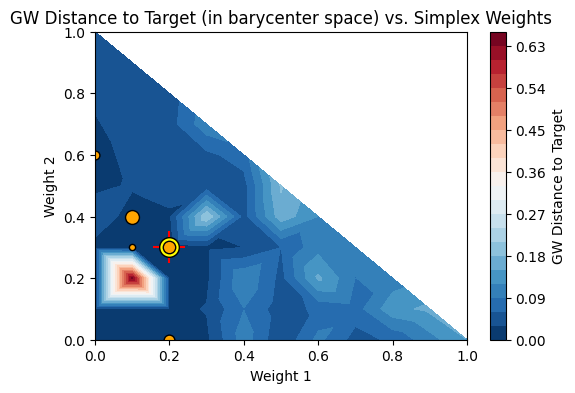

Real Barycentric Target found


  8%|▊         | 5/66 [00:00<00:01, 45.22it/s]

[np.float64(28.23563369402289), np.float64(0.0)]
[np.float64(26.958492913137114), np.float64(1.707992007438524), np.float64(0.8847291853588775), np.float64(0.0)]
[np.float64(23.805788810254644), np.float64(3.1236513455900643), np.float64(1.692511314125801), np.float64(0.4840769241711788), np.float64(0.0)]
[np.float64(27.616760314002775), np.float64(4.5628259841183665), np.float64(3.6569924380380425), np.float64(4.608510896434865), np.float64(0.2650569189073214), np.float64(0.0)]
[np.float64(27.660932625817505), np.float64(3.1105229575645077), np.float64(2.975245167541839), np.float64(4.403916250154373), np.float64(0.9412988957981421), np.float64(0.0)]
[np.float64(26.479909210579148), np.float64(7.717677884537159), np.float64(3.5732654366027385), np.float64(1.1951179858787648), np.float64(0.4710666101724524), np.float64(0.0)]
[np.float64(25.758617591129344), np.float64(5.340709084902733), np.float64(1.0013835241082627), np.float64(0.0)]
[np.float64(25.989115177903738), np.float64(1.1985

 15%|█▌        | 10/66 [00:00<00:01, 45.20it/s]

[np.float64(27.97737117280273), np.float64(1.5545014960684724), np.float64(0.0)]
[np.float64(28.24416980196716), np.float64(0.0)]
[np.float64(24.27844604156592), np.float64(1.4096422072491324), np.float64(5.501354576345188), np.float64(0.921418695413502), np.float64(6.004945894716635), np.float64(1.3206900418527399), np.float64(1.139490516455015), np.float64(6.105132521778608), np.float64(1.3907461134076988), np.float64(1.309248866419939), np.float64(6.071803088353324), np.float64(1.3688401621856594), np.float64(1.6661812573933477), np.float64(1.6144771929234516), np.float64(1.194485596640704), np.float64(0.09480472310972525), np.float64(0.0)]
[np.float64(26.24842655315626), np.float64(2.6787343067792477), np.float64(1.505219620620512), np.float64(2.0125630857330794), np.float64(1.897893502571644), np.float64(0.248309341387258), np.float64(0.0)]
[np.float64(28.00035956275034), np.float64(5.758201366452682), np.float64(2.1621041047497713), np.float64(1.820460414308688), np.float64(1.386

 23%|██▎       | 15/66 [00:05<00:22,  2.22it/s]

[np.float64(25.941588202578917), np.float64(4.345335872614861), np.float64(3.741917312436096), np.float64(5.677108402251645), np.float64(1.9956470729677427), np.float64(0.8781361939574982), np.float64(0.4123759425217563), np.float64(0.12723141640355867), np.float64(0.12723141640355867), np.float64(0.12723141640355867), np.float64(0.12723141640355867), np.float64(0.12723141640355867), np.float64(0.12723141640355867), np.float64(0.12723141640355867), np.float64(0.12723141640355867), np.float64(0.12723141640355867), np.float64(0.12723141640355867), np.float64(0.12723141640355867), np.float64(0.12723141640355867), np.float64(0.12723141640355867), np.float64(0.12723141640355867), np.float64(0.12723141640355867), np.float64(0.12723141640355867), np.float64(0.12723141640355867), np.float64(0.12723141640355867), np.float64(0.12723141640355867), np.float64(0.12723141640355867), np.float64(0.12723141640355867), np.float64(0.12723141640355867), np.float64(0.12723141640355867), np.float64(0.127231

 27%|██▋       | 18/66 [00:13<00:53,  1.12s/it]

[np.float64(27.0830788704061), np.float64(5.357973562192564), np.float64(1.1679249937093248), np.float64(4.633821053720149), np.float64(2.1257750218899476), np.float64(1.7715632873766909), np.float64(0.8460029065540157), np.float64(0.0)]
[np.float64(27.90151232823469), np.float64(2.496985078245268), np.float64(0.6558007667878744), np.float64(2.3262591242639203), np.float64(2.2343159728629516), np.float64(0.7799134700723309), np.float64(0.6723936189905741), np.float64(0.0)]
[np.float64(29.185053026081764), np.float64(0.9893859276127445), np.float64(0.9124078286828124), np.float64(0.752291611249769), np.float64(0.0)]


 33%|███▎      | 22/66 [00:16<00:41,  1.05it/s]

[np.float64(26.94226287804084), np.float64(2.9137668431796446), np.float64(1.1368193203182522), np.float64(1.958758505962355), np.float64(0.34180569440637115), np.float64(0.6022286521810005), np.float64(0.2744529502472722), np.float64(0.45538101803888636), np.float64(0.6022286521810005), np.float64(0.2744529502472722), np.float64(0.45538101803888636), np.float64(0.6022286521810005), np.float64(0.2744529502472722), np.float64(0.45538101803888636), np.float64(0.6022286521810005), np.float64(0.2744529502472722), np.float64(0.45538101803888636), np.float64(0.6022286521810005), np.float64(0.2744529502472722), np.float64(0.45538101803888636), np.float64(0.6022286521810005), np.float64(0.2744529502472722), np.float64(0.45538101803888636), np.float64(0.6022286521810005), np.float64(0.2744529502472722), np.float64(0.45538101803888636), np.float64(0.6022286521810005), np.float64(0.2744529502472722), np.float64(0.45538101803888636), np.float64(0.6022286521810005), np.float64(0.2744529502472722), 

 36%|███▋      | 24/66 [00:16<00:32,  1.28it/s]

[np.float64(27.22621791499924), np.float64(4.349120180743384), np.float64(2.7297662718253526), np.float64(2.7523887219490777), np.float64(2.3662912507215723), np.float64(2.2208371242110463), np.float64(3.146457085598195), np.float64(3.3107657595594118), np.float64(4.745529419963892), np.float64(2.908649690594908), np.float64(2.604050996611878), np.float64(3.3629248222288997), np.float64(4.328151856478965), np.float64(4.1549749666715865), np.float64(5.487996991928), np.float64(2.001605007950565), np.float64(3.1490185254772887), np.float64(3.4261865177530595), np.float64(1.63201322011841), np.float64(2.8054232065697917), np.float64(1.8630309793907391), np.float64(1.6772220760164174), np.float64(3.97891207611836), np.float64(3.0666689412568044), np.float64(3.410994826749633), np.float64(2.573157624711979), np.float64(4.493577900286131), np.float64(3.980097584984766), np.float64(4.334948688386218), np.float64(2.687874381556183), np.float64(2.478718398597875), np.float64(3.873887972654664),

 39%|███▉      | 26/66 [00:18<00:36,  1.10it/s]

[np.float64(25.668282769203373), np.float64(4.453529853903038), np.float64(2.7841297810875436), np.float64(3.807234362963798), np.float64(3.932109081019354), np.float64(1.4203460500077887), np.float64(1.2816655391281853), np.float64(0.8023402381338507), np.float64(0.31523143444071006), np.float64(1.570591797702291), np.float64(1.2288573323813965), np.float64(0.8023402381338507), np.float64(0.31523143444071006), np.float64(1.570591797702291), np.float64(1.2288573323813965), np.float64(0.8023402381338507), np.float64(0.31523143444071006), np.float64(1.570591797702291), np.float64(1.2288573323813965), np.float64(0.8023402381338507), np.float64(0.31523143444071006), np.float64(1.570591797702291), np.float64(1.2288573323813965), np.float64(0.8023402381338507), np.float64(0.31523143444071006), np.float64(1.570591797702291), np.float64(1.2288573323813965), np.float64(0.8023402381338507), np.float64(0.31523143444071006), np.float64(1.570591797702291), np.float64(1.2288573323813965), np.float64

 48%|████▊     | 32/66 [00:19<00:14,  2.32it/s]

[np.float64(26.463621875144035), np.float64(6.79616486767968), np.float64(2.786926317029043), np.float64(4.88155252373233), np.float64(2.0525124241584165), np.float64(0.656469033013994), np.float64(1.5818657957353086), np.float64(2.555957558707091), np.float64(2.70143722262969), np.float64(2.5353881372220206), np.float64(1.8864831666089688), np.float64(1.93228834947257), np.float64(2.2978830461509565), np.float64(1.7612271813920004), np.float64(2.108983655407446), np.float64(2.2356345285178567), np.float64(1.611169317505551), np.float64(2.702873237708552), np.float64(3.0474344041793944), np.float64(2.9675405173551224), np.float64(4.37169682324149), np.float64(2.3413430134976125), np.float64(0.6471817911082691), np.float64(1.762551872981978), np.float64(5.793578644223501), np.float64(2.531756306491542), np.float64(4.624120906816476), np.float64(2.0487494635662262), np.float64(2.1275539982036267), np.float64(1.8665706408867437), np.float64(2.484749798659302), np.float64(1.966504994915270

 56%|█████▌    | 37/66 [00:19<00:07,  3.87it/s]

[np.float64(27.967518314597132), np.float64(7.332812807784913), np.float64(6.779992832195041), np.float64(2.3710214884667575), np.float64(2.539913598192542), np.float64(0.17090284720318571), np.float64(0.0)]
[np.float64(28.541315943821335), np.float64(2.732787955375593), np.float64(0.9155878226859462), np.float64(1.0801406296361482), np.float64(2.047166454705193), np.float64(3.8654398677880524), np.float64(3.6410325159503176), np.float64(2.431421659103449), np.float64(3.784900604074973), np.float64(2.610168161350719), np.float64(2.393520756225833), np.float64(2.9616528544651537), np.float64(4.079534102638562), np.float64(3.7827005400446705), np.float64(4.014659517356293), np.float64(3.441774886866601), np.float64(4.602409378637089), np.float64(3.54773478825754), np.float64(2.314957607650616), np.float64(0.745457638450264), np.float64(2.6615081317202116), np.float64(1.8035546730366419), np.float64(1.671125196427795), np.float64(1.1226590404577126), np.float64(0.5144366780353435), np.flo

 61%|██████    | 40/66 [00:19<00:04,  5.39it/s]

[np.float64(29.679674896309976), np.float64(3.1820997669884568), np.float64(1.9974482335729156), np.float64(0.0)]
[np.float64(27.758353429935003), np.float64(0.6014259992371782), np.float64(2.3733447167911725), np.float64(0.0)]
[np.float64(28.132629333460685), np.float64(3.4088573055024747), np.float64(4.239745651537057), np.float64(4.13684655322124), np.float64(1.292465351374844), np.float64(4.7975591252236836), np.float64(4.2304457851851875), np.float64(3.5064260473153026), np.float64(7.207332212050288), np.float64(5.651651152688097), np.float64(0.8934242727109658), np.float64(0.8745587135226849), np.float64(2.0914761072708874), np.float64(1.5783060404430653), np.float64(0.7938329475705126), np.float64(0.23887879451887103), np.float64(2.430010941397417), np.float64(0.7063320856446336), np.float64(0.0)]
[np.float64(27.7173965129962), np.float64(2.2066239294822942), np.float64(6.040765470715292), np.float64(5.678530438168084), np.float64(4.4608560346351585), np.float64(3.43803007816049

 68%|██████▊   | 45/66 [00:20<00:03,  6.96it/s]

[np.float64(26.99077290632601), np.float64(3.964414131421613), np.float64(3.945963919491933), np.float64(1.6606561864091987), np.float64(3.138545053848014), np.float64(1.4736978676777774), np.float64(4.093131044184187), np.float64(1.8484356131601019), np.float64(1.8967738340621247), np.float64(4.034326999903535), np.float64(5.063499332138278), np.float64(3.2178690400906866), np.float64(3.0475553958750177), np.float64(1.2448936551124286), np.float64(0.2573945800945628), np.float64(0.1444689787264118), np.float64(1.1834094440650191), np.float64(4.212088145107294), np.float64(4.404366167808596), np.float64(3.1788114728450148), np.float64(3.5413263671787836), np.float64(4.853130880815394), np.float64(0.8401904443038678), np.float64(2.394970233772378), np.float64(4.6300290339269115), np.float64(1.4956394924793726), np.float64(1.578697844894064), np.float64(1.6544816652202947), np.float64(5.423591082204451), np.float64(5.897952490474835), np.float64(5.297869569013581), np.float64(3.347340720

 80%|████████  | 53/66 [00:20<00:00, 13.41it/s]

[np.float64(28.05376691166538), np.float64(3.287006548225045), np.float64(4.719346410276178), np.float64(3.616682867833312), np.float64(2.7293024635103236), np.float64(6.243819226744895), np.float64(3.3575487669871826), np.float64(1.5974780567107003), np.float64(0.965378378762488), np.float64(1.3268928192207672), np.float64(0.4504511670662223), np.float64(0.20111123851315701), np.float64(0.0)]
[np.float64(28.45510560765573), np.float64(4.172449679904764), np.float64(2.3922118675419557), np.float64(5.627098380220341), np.float64(0.7882603502829868), np.float64(0.7992124780408444), np.float64(0.0)]
[np.float64(26.865414823876613), np.float64(2.7346370949338206), np.float64(0.7163480553045909), np.float64(0.16336143819616086), np.float64(0.0)]
[np.float64(28.559380806442796), np.float64(4.77919648789081), np.float64(4.693388993191935), np.float64(3.6594333168652287), np.float64(3.899392173429095), np.float64(0.14865994465101265), np.float64(0.7325933197846629), np.float64(0.0)]
[np.float6

 85%|████████▍ | 56/66 [00:22<00:02,  4.24it/s]

[np.float64(27.280206056587023), np.float64(2.106392008723283), np.float64(6.824256226517246), np.float64(3.4169487488439656), np.float64(3.53177365554385), np.float64(2.0568895803255236), np.float64(0.7701512027623905), np.float64(1.1279443568445056), np.float64(0.3127360778091656), np.float64(0.30231085408519837), np.float64(0.30231085408519837), np.float64(0.30231085408519837), np.float64(0.30231085408519837), np.float64(0.30231085408519837), np.float64(0.30231085408519837), np.float64(0.30231085408519837), np.float64(0.30231085408519837), np.float64(0.30231085408519837), np.float64(0.30231085408519837), np.float64(0.30231085408519837), np.float64(0.30231085408519837), np.float64(0.30231085408519837), np.float64(0.30231085408519837), np.float64(0.30231085408519837), np.float64(0.30231085408519837), np.float64(0.30231085408519837), np.float64(0.30231085408519837), np.float64(0.30231085408519837), np.float64(0.30231085408519837), np.float64(0.30231085408519837), np.float64(0.302310854

 88%|████████▊ | 58/66 [00:28<00:06,  1.28it/s]

[np.float64(28.0953004342124), np.float64(2.4457021812117885), np.float64(0.7980626909855951), np.float64(1.3006256967329555), np.float64(1.043073108292796), np.float64(1.3404495145605908), np.float64(0.8889988993896858), np.float64(0.988842950903506), np.float64(0.9847463219899907), np.float64(0.7352475705513238), np.float64(0.24838657221210883), np.float64(0.8624715147112038), np.float64(1.0436021057247242), np.float64(3.4267357475616222), np.float64(2.952854509956236), np.float64(0.7272944593557666), np.float64(0.6111491881694573), np.float64(3.365240543308984), np.float64(2.952854509956236), np.float64(0.7272944593557666), np.float64(0.6111491881694573), np.float64(3.365240543308984), np.float64(2.952854509956236), np.float64(0.7272944593557666), np.float64(0.6111491881694573), np.float64(3.365240543308984), np.float64(2.952854509956236), np.float64(0.7272944593557666), np.float64(0.6111491881694573), np.float64(3.365240543308984), np.float64(2.952854509956236), np.float64(0.727294

 91%|█████████ | 60/66 [00:35<00:08,  1.47s/it]

[np.float64(29.677244256104984), np.float64(4.98598959388753), np.float64(3.500684733172562), np.float64(1.489714656471634), np.float64(3.7525341589762435), np.float64(2.550780652025092), np.float64(2.550780652025092), np.float64(2.550780652025092), np.float64(2.550780652025092), np.float64(2.550780652025092), np.float64(2.550780652025092), np.float64(2.550780652025092), np.float64(2.550780652025092), np.float64(2.550780652025092), np.float64(2.550780652025092), np.float64(2.550780652025092), np.float64(2.550780652025092), np.float64(2.550780652025092), np.float64(2.550780652025092), np.float64(2.550780652025092), np.float64(2.550780652025092), np.float64(2.550780652025092), np.float64(2.550780652025092), np.float64(2.550780652025092), np.float64(2.550780652025092), np.float64(2.550780652025092), np.float64(2.550780652025092), np.float64(2.550780652025092), np.float64(2.550780652025092), np.float64(2.550780652025092), np.float64(2.550780652025092), np.float64(2.550780652025092), np.flo

100%|██████████| 66/66 [00:46<00:00,  1.43it/s]

[np.float64(30.811186260097706), np.float64(1.6854054009069588), np.float64(1.6425701505194086), np.float64(1.6425701505194086), np.float64(1.6425701505194086), np.float64(1.6425701505194086), np.float64(1.6425701505194086), np.float64(1.6425701505194086), np.float64(1.6425701505194086), np.float64(1.6425701505194086), np.float64(1.6425701505194086), np.float64(1.6425701505194086), np.float64(1.6425701505194086), np.float64(1.6425701505194086), np.float64(1.6425701505194086), np.float64(1.6425701505194086), np.float64(1.6425701505194086), np.float64(1.6425701505194086), np.float64(1.6425701505194086), np.float64(1.6425701505194086), np.float64(1.6425701505194086), np.float64(1.6425701505194086), np.float64(1.6425701505194086), np.float64(1.6425701505194086), np.float64(1.6425701505194086), np.float64(1.6425701505194086), np.float64(1.6425701505194086), np.float64(1.6425701505194086), np.float64(1.6425701505194086), np.float64(1.6425701505194086), np.float64(1.6425701505194086), np.floa

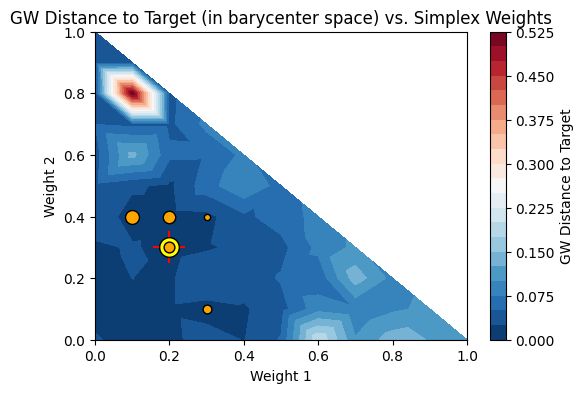

In [ ]:
#------------------------------------------------------------
# Plot distances to targets in Frobernius and GW cases when targets are different sythetized matrices of the same lambda weights
#------------------------------------------------------------
import math 

lambda_test  = np.array([0.2, 0.3, 0.5])

for _ in range(5):
    # ------------------------------------------------------------
    # Computre GW distances to original target and plot results
    # ------------------------------------------------------------
    for target_attempt in range(10):
        target_dist_matrix_synth = ot.gromov.gromov_barycenters(
            template_dist_matrix.shape[0], 
            Cs = deformed_dist_matrices, 
            lambdas=lambda_test, 
            loss_fun='square_loss'
            )
        B_blowup, b_blowup, temp_blow_up = utils.blow_up(deformed_dist_matrices, deformed_measures, target_dist_matrix_synth, ot.unif(target_dist_matrix_synth.shape[0]))
        a = utils.get_lambdas_blowup_matrix(temp_blow_up, B_blowup, b_blowup)

        if math.isclose(a, 0.0, rel_tol=1e-12, abs_tol=1e-15):
            print("Real Barycentric Target found")
            break
    
    simplex_grid_points = simplex_grid(N=10)
    simplex_GW_distances_to_target = []
    for weight_idx, weight in enumerate(tqdm(simplex_grid_points)):
        weights = weight / np.sum(weight)  # Normalize to sum to 1
        try:
            for bary_attempt in range(5):
                #print(bary_attempt)
                true_bary = False
                signal.alarm(10)
                barycenter_dist_matrix, log = ot.gromov.gromov_barycenters(
                    template_dist_matrix.shape[0], 
                    Cs = deformed_dist_matrices, 
                    lambdas=weights, 
                    loss_fun='square_loss',
                    log=True
                )
                signal.alarm(0)  # Disable the alarm
                B_blowup, b_blowup, temp_blow_up = utils.blow_up(deformed_dist_matrices, deformed_measures, barycenter_dist_matrix, ot.unif(barycenter_dist_matrix.shape[0]))
                a = utils.get_lambdas_blowup_matrix(temp_blow_up, B_blowup, b_blowup) # Recompute lambdas from blow-up matrices
                print(a)

                if math.isclose(a, 0.0, rel_tol=1e-12, abs_tol=1e-15):
                    gw_dist_to_target = ot.gromov.gromov_wasserstein2(
                        barycenter_dist_matrix,
                        target_dist_matrix_synth,
                        ot.unif(barycenter_dist_matrix.shape[0]),
                        ot.unif(target_dist_matrix_synth.shape[0]),
                        'square_loss'
                        )
                    
                    simplex_GW_distances_to_target.append(gw_dist_to_target)
                    true_bary = True
                    #print(f'True bary at {weights}')
                    break
            #print('About to check')    
            if  not true_bary:
                #print(f'Not true bary found at {weights}')
                raise TimeoutException
            
        except TimeoutException:
            simplex_GW_distances_to_target.append(np.nan)
            #print('Added NaN')        


    # Clean up NaN values for plotting
    z = np.array(simplex_GW_distances_to_target)
    mask = np.isnan(z)
    z_masked = z[~mask]
    x_grid_points = simplex_grid_points[~mask,0]
    y_grid_points = simplex_grid_points[~mask,1]
    min_simplex_grid_points = simplex_grid_points[z.argsort()[:5]]

    # Plot GW distances to target vs. simplex weights
    plt.figure(figsize=(6,4))
    plt.tricontourf(x_grid_points, y_grid_points, z_masked, levels=24, cmap="RdBu_r")
    plt.colorbar(label='GW Distance to Target')
    plt.xlabel('Weight 1')
    plt.ylabel('Weight 2')
    plt.title('GW Distance to Target (in barycenter space) vs. Simplex Weights')
    # # Plot triangulation grid
    # triang = tri.Triangulation(x_grid_points, y_grid_points)
    # plt.triplot(triang, color='k', alpha=0.3)
    # Plot true and recovered weights
    plt.scatter(lambda_test[0], lambda_test[1], marker = '+',  color='red', s=500, edgecolor='k', label='Target')
    _, lambdas = utils.get_lambdas_constraints(deformed_dist_matrices,deformed_measures,target_dist_matrix_synth, ot.unif(target_dist_matrix_synth.shape[0]))
    plt.scatter(lambdas[0], lambdas[1], color='yellow', s=200, edgecolor='k', label='Computed Weights our algorithm')
    for index, min_point in enumerate(min_simplex_grid_points):
        plt.scatter(min_point[0], min_point[1], color='orange', s=100-20*index, edgecolor='k', label=f'GW Min Weights N {index+1}')
    #plt.legend()
    plt.show()

In [ ]:
print(ot.__version__)

0.9.6.post1
